In [1]:
import numpy as np
from scipy import fft, optimize
import NAFFlib as naf
import statistics as st
import matplotlib.pyplot as plt
import time
from IPython.display import display, Math
import re
import csv

#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)

# BPM Data

In [2]:
#Get data from all BPMs from sdds file
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 168])
Pos_ybpms = np.zeros([1024, 167])
S_xbpms = np.zeros([1024, 168])
S_ybpms = np.zeros([1024, 167])
with open('data_Wed_Jun_28_20-13-14_2023') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%168
            
            if (i - init_i)%168 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 171423:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%167
            
            if (i - init_i)%167 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [3]:
# Positions
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1024-init_turn)
N_BPMy, _ = np.shape(BPMy) #(167, 1024-init_turn)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of First Horizontal BPM = 0.08086005371776343


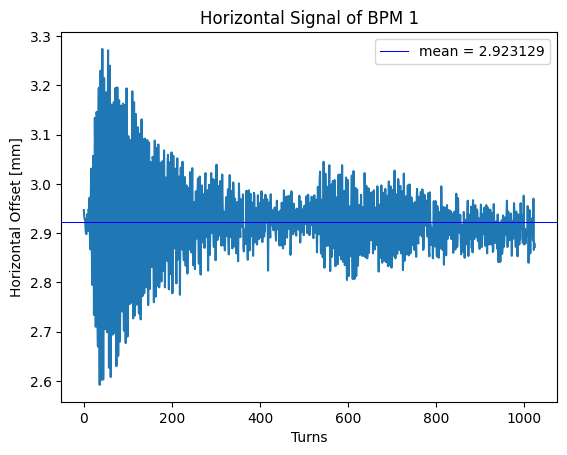

Standard deviation of First Vertical BPM = 0.14039846131415454


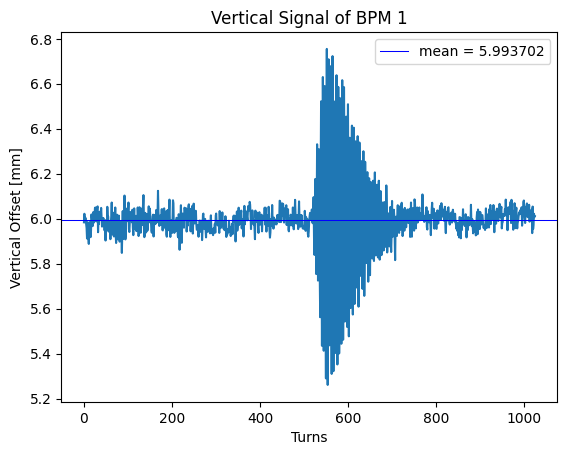

In [4]:
# Look at first BPM Signals
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal Signal of BPM 1")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of First Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical Signal of BPM 1")
plt.legend()
plt.show()

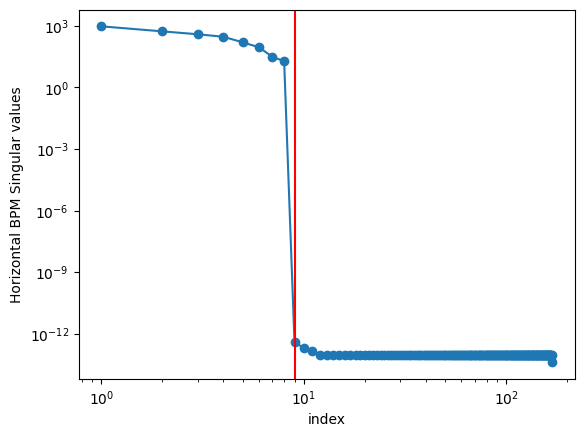

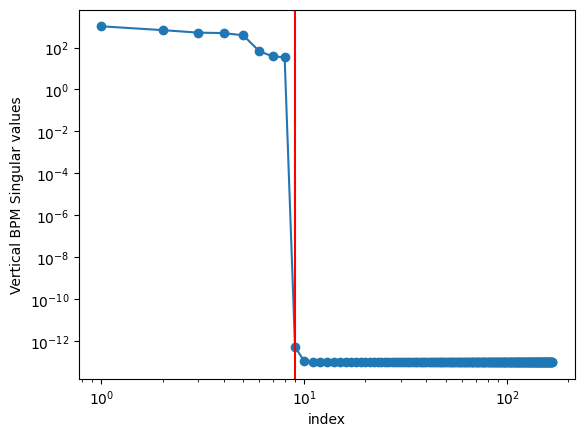

In [19]:
Ux, Sx, Vx = np.linalg.svd(BPMx)#, full_matrices = False)
keep_nx = 9
plt.plot(np.linspace(1, len(Sx), len(Sx)), Sx, '-o')
plt.yscale('log')
plt.axvline(x=keep_nx, color='r', linestyle='-')
plt.xscale('log')
plt.xlabel("index")
plt.ylabel("Horizontal BPM Singular values")
plt.show()

Uy, Sy, Vy = np.linalg.svd(BPMy)#, full_matrices = False)
keep_ny = 9
plt.plot(np.linspace(1, len(Sy), len(Sy)), Sy, '-o')
plt.yscale('log')
plt.axvline(x=keep_ny, color='r', linestyle='-')
plt.xscale('log')
plt.xlabel("index")
plt.ylabel("Vertical BPM Singular values")
plt.show()


In [27]:
print(Ux.shape)
print(BPMx.shape)
plt.plot(Ux @ Sxmat[0] @ Vx)
plt.show()

(168, 168)
(168, 1024)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1024 is different from 168)

In [6]:
# Reconstruction:
Sxmat = np.zeros((len(Ux), len(Vx)), dtype=complex)
Sxmat[:keep_nx - 1, :keep_nx - 1] = np.diag(Sx[:keep_nx - 1])
BPMx = Ux @ Sxmat @ Vx
BPMx = np.real(BPMx)

Symat = np.zeros((len(Uy), len(Vy)), dtype=complex)
Symat[:keep_ny - 1, :keep_ny - 1] = np.diag(Sy[:keep_ny - 1])
BPMy = Uy @ Symat @ Vy
BPMy = np.real(BPMy)

Standard deviation of First Horizontal BPM = 0.07786226567096849


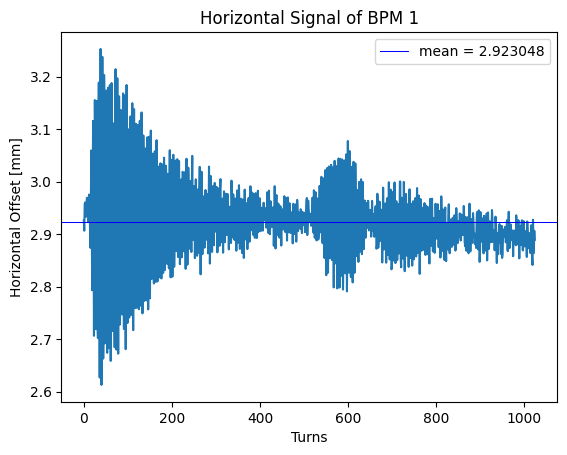

Standard deviation of First Vertical BPM = 0.13848657632678163


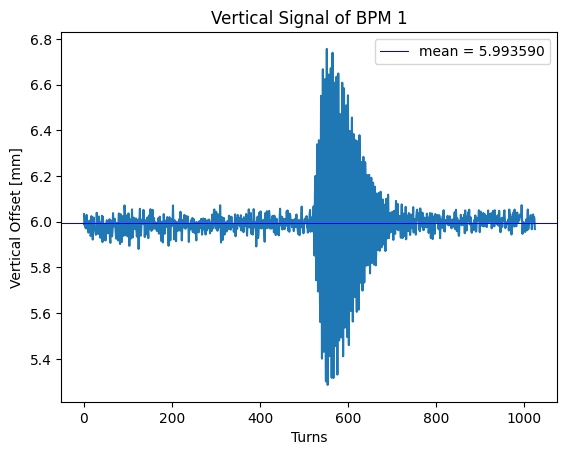

In [7]:
# Look at first BPM Signals
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal Signal of BPM 1")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of First Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical Signal of BPM 1")
plt.legend()
plt.show()

0.23483365949119372


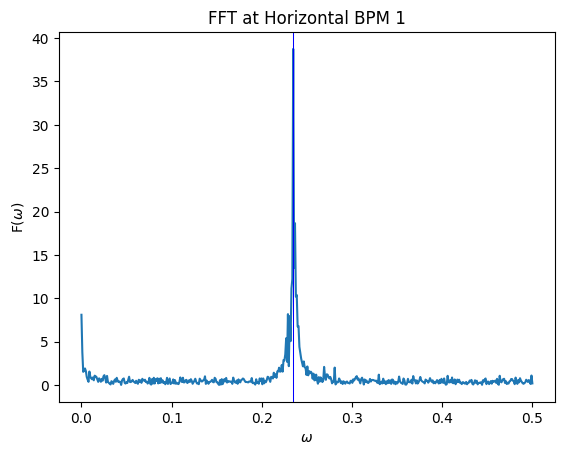

0.22798434442270057


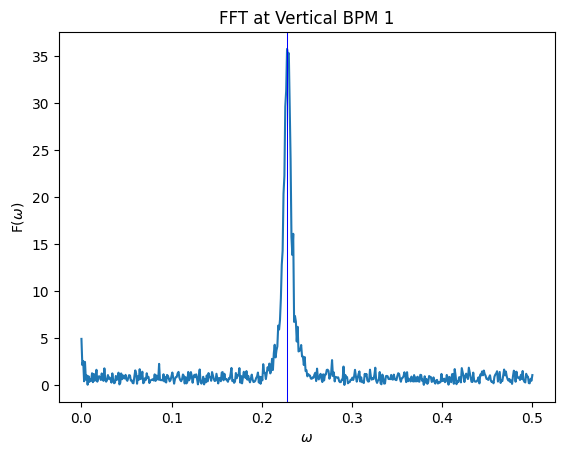

In [8]:
# Look at First BPM FFTs
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
print(BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at Horizontal BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
print(BPMy0_Tune_scipy)
plt.plot(Omega, BPMY0)
plt.axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
plt.title("FFT at Vertical BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

0.00016808850880467574 0.0010185889772997558


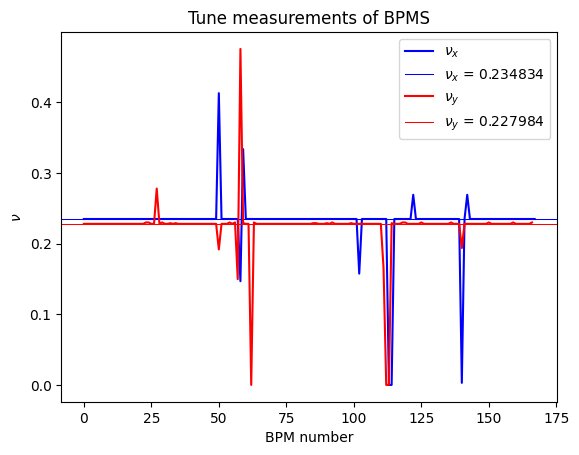

In [9]:
# Look at all FFTs to figure out Tune of machine
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from experiment
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)
print(delta_nu_x, delta_nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [10]:
# Collect bad BPMs
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .01:
            Bad_BPM.append(i)
    return Bad_BPM
print(Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print(Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

[50, 58, 59, 102, 113, 114, 122, 140, 142]
[27, 50, 57, 58, 62, 111, 112, 113, 140]


## Phase Transfer Matrix Calculation

In [11]:
# print(Name_ybpms[50:])
print(S_xbpms[0])

[   7.99309015   25.0237827    36.8996124    66.644371     73.1987381
   95.8533554   113.003113    126.112198    154.946014    184.603134
  214.260269    243.917404    273.574524    303.231659    332.888794
  362.545929    392.203064    421.860199    451.517334    481.174469
  513.332947    526.441772    543.591675    566.246277    572.800659
  602.54541     614.421265    631.118713    647.771362    664.468811
  676.344666    706.089417    712.643799    720.473755    752.408813
  765.517639    782.824585    812.423706    842.010742    871.597778
  901.184875    930.771912    960.359009    989.946045   1019.53308
 1049.12012    1078.70728    1108.29431    1134.56885    1151.87573
 1158.43018    1164.98462    1196.91968    1204.77502    1231.29358
 1241.04883    1252.92456    1269.62207    1273.87598    1275.41675
 1286.27478    1302.97217    1314.84802    1329.69397    1351.1217
 1373.80176    1390.95166    1404.06055    1432.89441    1462.55151
 1492.20862    1521.86584    1551.52295 

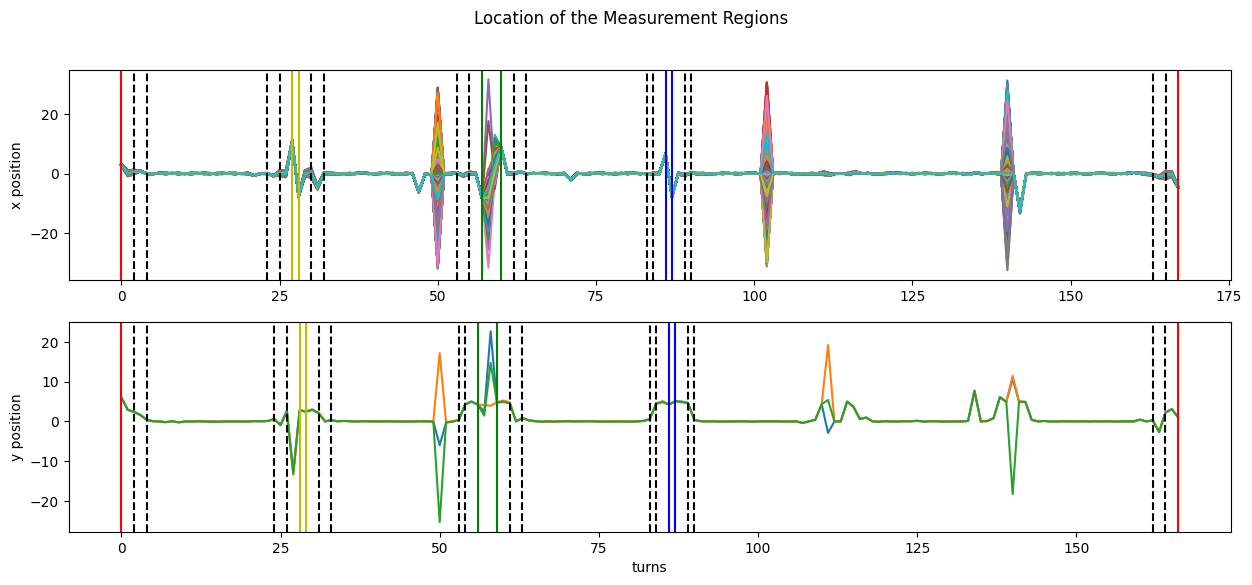

In [12]:
fig, Ax = plt.subplots(2, 1, figsize = (15, 6))
for i in range(500):
    Ax[0].plot(Pos_xbpms[i, :])
# Ax[0].plot(Pos_xbpms[0, :])
# Ax[0].plot(Pos_xbpms[36, :])
fig.suptitle("Location of the Measurement Regions")

#IP6
Ax[0].axvline(x = 163, color = 'k', ls = '--')
Ax[0].axvline(x = 165, color = 'k', ls = '--')

Ax[0].axvline(x = 167, color = 'r')
Ax[0].axvline(x = 0, color = 'r')

Ax[0].axvline(x = 2, color = 'k', ls = '--')
Ax[0].axvline(x = 4, color = 'k', ls = '--')

#IP8
Ax[0].axvline(x = 23, color = 'k', ls = '--')
Ax[0].axvline(x = 25, color = 'k', ls = '--')

Ax[0].axvline(x = 27, color = 'y')
Ax[0].axvline(x = 28, color = 'y')

Ax[0].axvline(x = 30, color = 'k', ls = '--')
Ax[0].axvline(x = 32, color = 'k', ls = '--')

#IP10
Ax[0].axvline(x = 53, color = 'k', ls = '--')
Ax[0].axvline(x = 55, color = 'k', ls = '--')

Ax[0].axvline(x = 57, color = 'g')
Ax[0].axvline(x = 60, color = 'g')

Ax[0].axvline(x = 62, color = 'k', ls = '--')
Ax[0].axvline(x = 64, color = 'k', ls = '--')

#IP12
Ax[0].axvline(x = 83, color = 'k', ls = '--')
Ax[0].axvline(x = 84, color = 'k', ls = '--')

Ax[0].axvline(x = 86, color = 'b')
Ax[0].axvline(x = 87, color = 'b')

Ax[0].axvline(x = 89, color = 'k', ls = '--')
Ax[0].axvline(x = 90, color = 'k', ls = '--')

Ax[1].plot(Pos_ybpms[35, :])
Ax[1].plot(Pos_ybpms[36, :])
Ax[1].plot(Pos_ybpms[39, :])

#IP6
Ax[1].axvline(x = 162, color = 'k', ls = '--')
Ax[1].axvline(x = 164, color = 'k', ls = '--')

Ax[1].axvline(x = 0, color = 'r')
Ax[1].axvline(x = 166, color = 'r')

Ax[1].axvline(x = 2, color = 'k', ls = '--')
Ax[1].axvline(x = 4, color = 'k', ls = '--')

#IP8
Ax[1].axvline(x = 24, color = 'k', ls = '--')
Ax[1].axvline(x = 26, color = 'k', ls = '--')

Ax[1].axvline(x = 28, color = 'y')
Ax[1].axvline(x = 29, color = 'y')

Ax[1].axvline(x = 31, color = 'k', ls = '--')
Ax[1].axvline(x = 33, color = 'k', ls = '--')

#IP10
Ax[1].axvline(x = 53, color = 'k', ls = '--')
Ax[1].axvline(x = 54, color = 'k', ls = '--')

Ax[1].axvline(x = 56, color = 'g')
Ax[1].axvline(x = 59, color = 'g')

Ax[1].axvline(x = 61, color = 'k', ls = '--')
Ax[1].axvline(x = 63, color = 'k', ls = '--')

#IP12
Ax[1].axvline(x = 83, color = 'k', ls = '--')
Ax[1].axvline(x = 84, color = 'k', ls = '--')

Ax[1].axvline(x = 86, color = 'b')
Ax[1].axvline(x = 87, color = 'b')

Ax[1].axvline(x = 89, color = 'k', ls = '--')
Ax[1].axvline(x = 90, color = 'k', ls = '--')

Ax[0].set_ylabel("x position")

Ax[1].set_xlabel("turns")
Ax[1].set_ylabel("y position")

plt.show()

## Linear Regression Calculation

In [13]:
def Mat_param(result):
    M = result.coef_
    print("M:")
    print(M)

    det = np.linalg.det(M)
    print("determinant:", det)
    M /= (np.sqrt(det))
    print("determinant after normalization:", np.linalg.det(M))
    print("M after normalization:")
    print(M)
    return M
    
def Twiss_calc(M):
    phi = np.arccos((M[0, 0] + M[1, 1])/2)
    beta = M[0, 1]/np.sin(phi)
    alpha = (M[0, 0] - M[1, 1])/(2*np.sin(phi))
    beta2 = -(alpha**2 + 1)*np.sin(phi)/M[1, 0]

    print(phi/(2*np.pi))
    Twiss = np.array([phi, beta, beta2, alpha])

    return Twiss

In [14]:
def LR_calculation(Interval, BPM, S_bpms, Bpms, b_MADx, Name, ishor):
    bpm1, bpm2 = Bpms
    b1_m, b2_m = b_MADx
    
    #Organize position and speed data
    initial_turn, interval_turn = Interval
        
    # Scaled position and speed between two bpms
    C = 3834
    if S_bpms[0, bpm1] > S_bpms[0, bpm2]: L = S_bpms[0, bpm2] - S_bpms[0, bpm1] + C
    else: L = S_bpms[0, bpm2] - S_bpms[0, bpm1]
    x_data1_all = BPM[bpm1] - np.mean(BPM[bpm1])
    x_data2_all = BPM[bpm2] - np.mean(BPM[bpm2])
    xp_data_all = (x_data2_all - x_data1_all)/L

    # variable data: x_data (bpm, var) (current turn)
    x_data11 = x_data1_all[initial_turn: initial_turn + interval_turn]
    x_data12 = xp_data_all[initial_turn: initial_turn + interval_turn]

    x_data21 = x_data2_all[initial_turn: initial_turn + interval_turn]
    x_data22 = xp_data_all[initial_turn: initial_turn + interval_turn]

    X_data1 = np.vstack((x_data11, x_data12)).T
    X_data2 = np.vstack((x_data21, x_data22)).T

    # Y Train data (next turn)
    y_data11 = x_data1_all[initial_turn + 1: initial_turn + interval_turn + 1]
    y_data12 = xp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]

    y_data21 = x_data2_all[initial_turn + 1: initial_turn + interval_turn + 1]
    y_data22 = xp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]

    Y_data1 = np.vstack((y_data11, y_data12)).T
    Y_data2 = np.vstack((y_data21, y_data22)).T
    
            
    #LR Calculation:
    # Y = MX + B; M: 2x2
    result1 = LinearRegression().fit(X_data1, Y_data1)
    result2 = LinearRegression().fit(X_data2, Y_data2)

    #Correlation:
    corr1 = result1.score(X_data1, Y_data1)
    corr2 = result2.score(X_data2, Y_data2)
    print("Correlation from bpm 1 & 2:") 
    print(corr1)
    print(corr2)
    print()
    
    #Prediction: Visualize correlation
    pred1 = result1.predict(X_data1)
    pred2 = result2.predict(X_data2)
    fig, Ax = plt.subplots(1, 2, figsize=(15, 6))
    Ax[0].scatter(pred1, Y_data1)
    Ax[0].set_title("prediction vs real for left bpm")
    Ax[0].set_xlabel("predicted next turn values")
    Ax[0].set_ylabel("Actual next turn values")
    
    Ax[1].scatter(pred2, Y_data2)
    Ax[1].set_title("prediction vs real for right bpm")
    Ax[1].set_xlabel("predicted next turn values")
    Ax[1].set_ylabel("Actual next turn values")
    plt.show()
    print()
    
    # Get Matrix M
    M1 = Mat_param(result1)
    M2 = Mat_param(result2)
    
    # Calculate Twiss parameters
    print("Tune from bpm 1 & 2:")
    Twiss1 = Twiss_calc(M1)
    Twiss2 = Twiss_calc(M2)
    print()
    print("Twiss:")
    print(Twiss1)
    print(Twiss2)
    print()
    phi1, b1, b12, alpha1 = Twiss1
    phi2, b2, b22, alpha2 = Twiss2

    print("Measured Beta for bpm 1, 2:", b1, b2)
    print("Model Beta for bpm 1, 2   :", b1_m, b2_m)
    print()
    print("beta beat at bpm 1, 2:")
    print((b1_m - b1)/b1_m)
    print((b2_m - b2)/b2_m)
    print()
    print()
    if ishor: axis = "x"
    else: axis = "y"
        
    fig, Ax = plt.subplots(1, 2, figsize=(15, 6))
    Ax[0].scatter(x_data11, x_data12)
    Ax[0].set_ylabel("%s' [mm]"%axis)
    Ax[0].set_xlabel("%s [mm], %s"%(axis, Name[bpm1]))
    
    Ax[1].scatter(x_data21, x_data22)
    Ax[1].set_ylabel("%s' [mm]"%axis)
    Ax[1].set_xlabel("%s [mm], %s"%(axis, Name[bpm2]))
    
    print("-----------------------------------------")
    return Twiss1, Twiss2

In [15]:
def bpm_signals(Bpms, BPM, Intervals, ishor):
    x = np.linspace(0, N_turns, N_turns)
    fig, Ax = plt.subplots(1, 2, figsize=(15, 3))
    fig.suptitle("BPM TBT Data")

    for i, bpm in enumerate(Bpms):
        iterx = i//2
        itery = i%2
        BPM0 = BPM[bpm]
        BPM0_mean = np.mean(BPM0)

        Ax[i].plot(x, BPM0)
        Ax[i].axhline(y = BPM0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPM0_mean)
        Ax[i].axvline(x = Intervals[0], color = 'k', linestyle = '--', linewidth = .75)
        Ax[i].axvline(x = Intervals[0] + Intervals[1], color = 'k', linestyle = '--', linewidth = .75)
        if itery == 0:
            if ishor: Ax[i].set_ylabel("Horizontal Offset [mm]")
            else: Ax[i].set_ylabel("Vertical Offset [mm]")
        if iterx == 1:
            if itery == 0: Ax[i].set_xlabel("Turns, %s"%Name_xbpms[bpm])
            else: Ax[i].set_xlabel("Turns, %s"%Name_ybpms[bpm])
        Ax[i].legend()
    plt.show()

In [16]:
def chrom(Interval_range, BPM, S_bpms, Bpms, b_MADx, is_hor):
    N = len(Interval_range)
    Beta1 = np.zeros(N)
    Beta2 = np.zeros(N)
    for i, interval in enumerate(Interval_range):
        interval = int(interval)
        if is_hor: Intervals = (30, interval)
        else: Intervals = (550, interval)
        Twiss1, Twiss2 = LR_calculation(Intervals, BPM, S_bpms, Bpms, b_MADx)
        Beta1[i] = Twiss1[1]
        Beta2[i] = Twiss2[1]
    fig, Ax = plt.subplots(1, 2, figsize=(15, 3))
    fig.suptitle("Nonlinearity")
    Ax[0].plot(Interval_range, Beta1, label = "beta measured")
    Ax[0].plot(Interval_range, (b_MADx[0] - Beta1), color = 'r', alpha = .5, label = "scaled beta beat")
    
    Ax[1].plot(Interval_range, Beta2, label = "beta measured")
    Ax[1].plot(Interval_range, (b_MADx[1] - Beta2), color = 'r', alpha = .5,  label = "scaled beta beat")
    
    for i in range(2):
        Ax[i].axhline(y = b_MADx[i], color = 'k', linestyle = '--', linewidth = .75, label = "beta model")
        Ax[i].set_ylim(-b_MADx[i], b_MADx[i]*2)
        Ax[i].set_ylabel("Beta value [m]")
        Ax[i].set_xlabel("Intervals")
    plt.legend()
    plt.show()
#     return Beta1, Beta2

### Around IP6

Bad Horizontal BPMs: [50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 140]


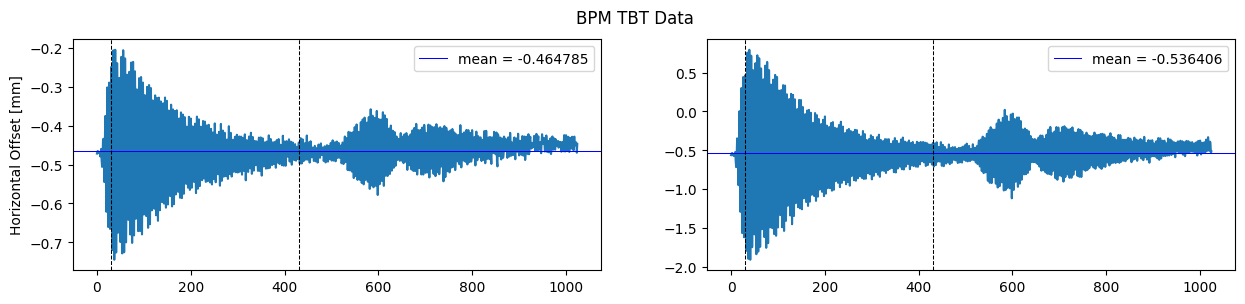

Correlation from bpm 1 & 2:
0.7323828520745332
0.7310886386630102



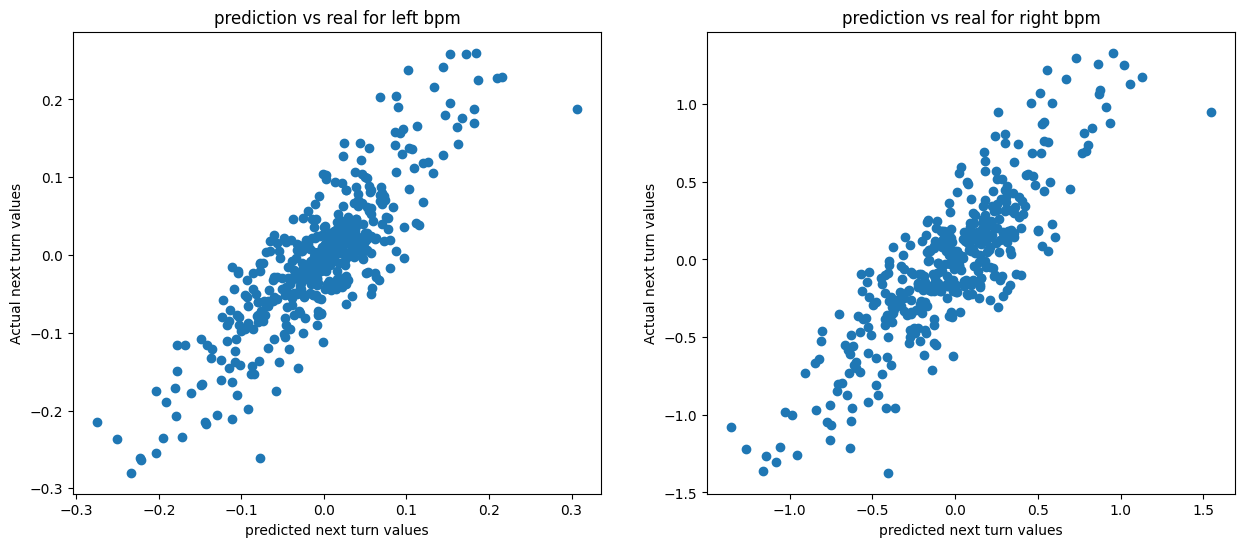


M:
[[-4.60709243 41.89674164]
 [-0.54250077  4.77564809]]
determinant: 0.7271626073480497
determinant after normalization: 0.9999999999999964
M after normalization:
[[-5.40270377 49.13200412]
 [-0.63618671  5.60036777]]
M:
[[ -24.29937143 1097.29320119]
 [  -0.54250077   24.46792709]]
determinant: 0.7271626073479476
determinant after normalization: 1.0000000000000107
M after normalization:
[[ -28.49569609 1286.78775411]
 [  -0.63618671   28.69336009]]
Tune from bpm 1 & 2:
0.23424467824725284
0.23424467824725656

Twiss:
[ 1.47180272 49.37373133 49.37373133 -5.52860308]
[   1.47180272 1293.11869109 1293.11869109  -28.73521187]

Measured Beta for bpm 1, 2: 49.373731334996435 1293.1186910893396
Model Beta for bpm 1, 2   : 67.80573273 1829.361467

beta beat at bpm 1, 2:
0.27183544300596435
0.293131120111573


-----------------------------------------


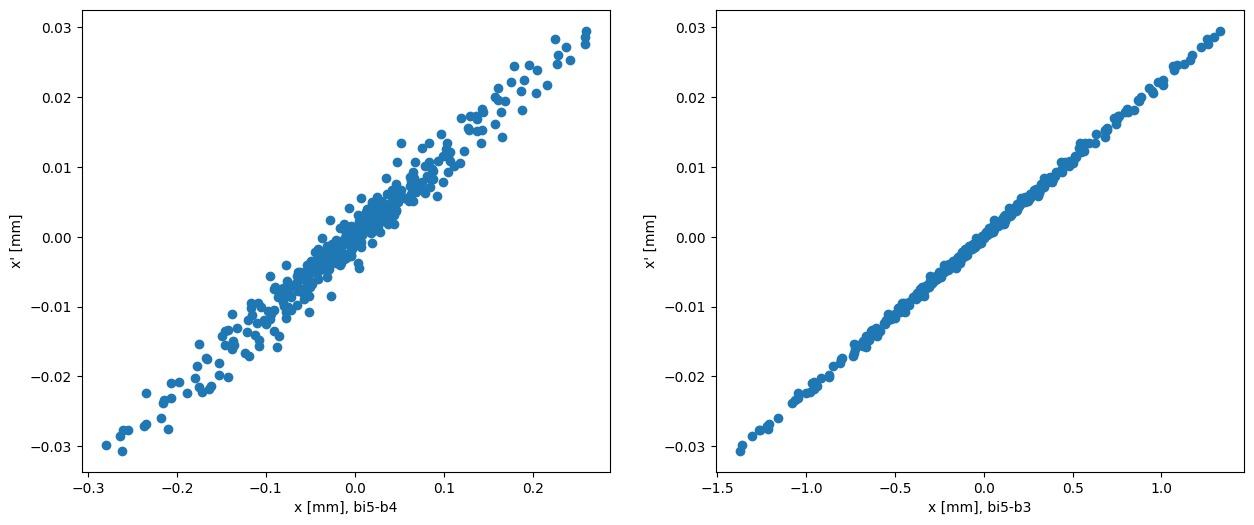

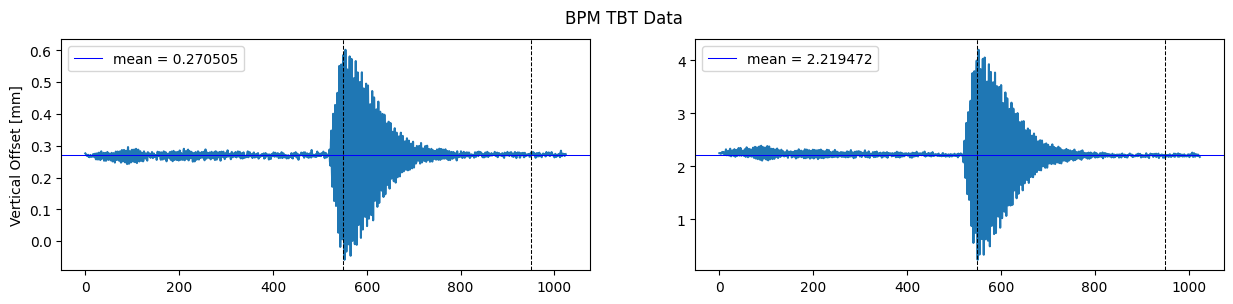

Correlation from bpm 1 & 2:
0.9454701169851993
0.946942365971208



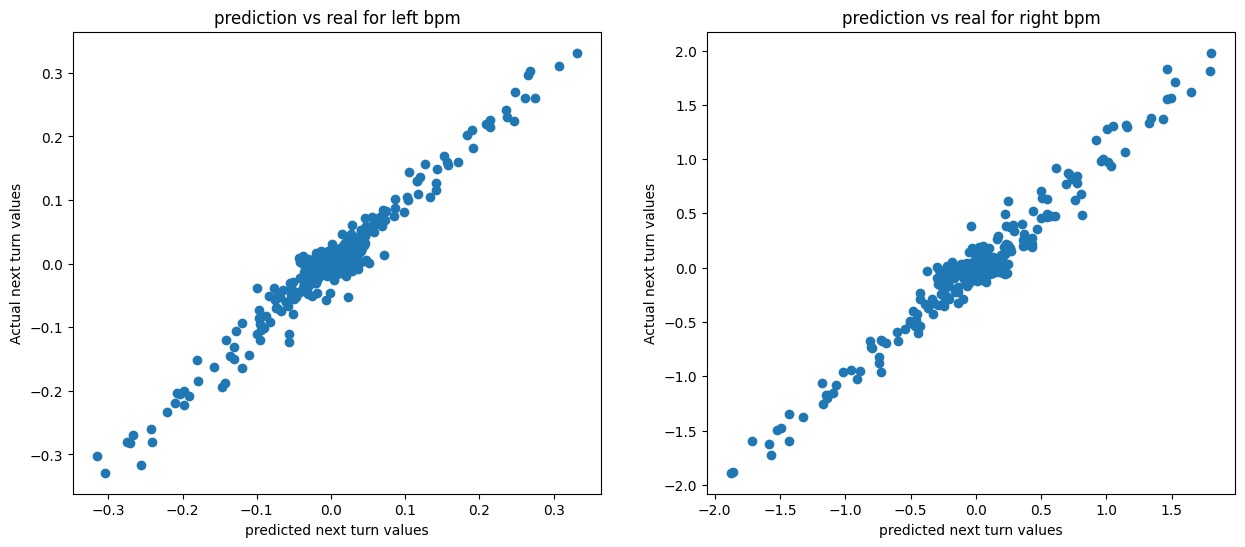


M:
[[ 4.96670065 26.13309169]
 [-0.93142388 -4.71398888]]
determinant: 0.9280140941640747
determinant after normalization: 0.9999999999999984
M after normalization:
[[ 5.15573633 27.12773324]
 [-0.96687445 -4.8934062 ]]
M:
[[-28.84312936 901.99869248]
 [ -0.93142388  29.09584113]]
determinant: 0.9280140941640934
determinant after normalization: 1.0000000000001195
M after normalization:
[[-29.94091662 936.32931775]
 [ -0.96687445  30.20324675]]
Tune from bpm 1 & 2:
0.22906410495811472
0.22906410495811463

Twiss:
[ 1.43925222 27.3641446  27.3641446   5.06835914]
[  1.43925222 944.4891919  944.4891919  -30.3341523 ]

Measured Beta for bpm 1, 2: 27.364144602186467 944.4891918982273
Model Beta for bpm 1, 2   : 21.48144505 662.1839248

beta beat at bpm 1, 2:
-0.27385027117561
-0.4263245550448725


-----------------------------------------


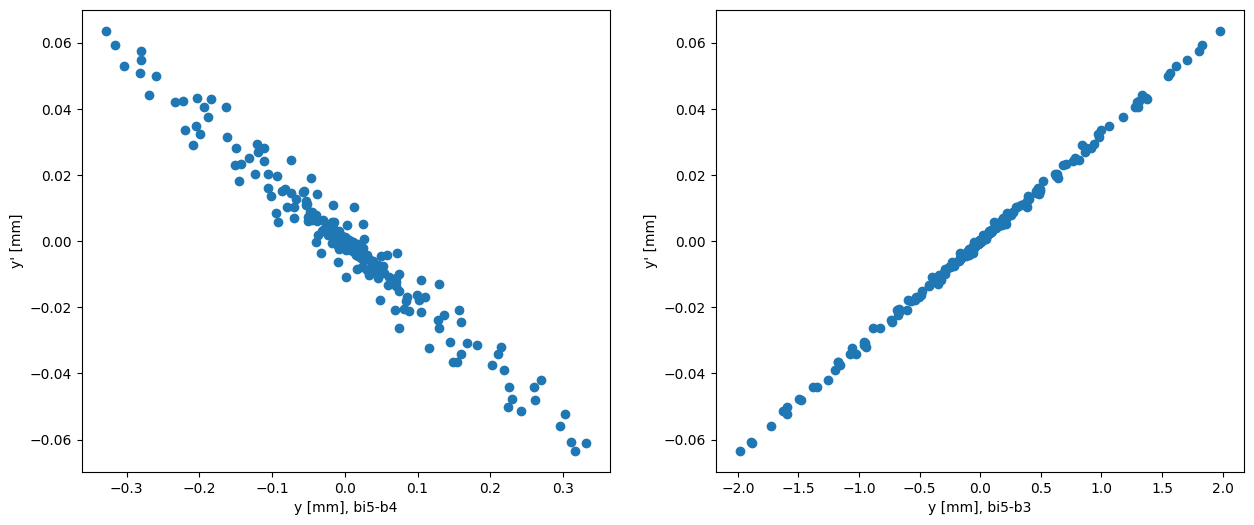

In [302]:
interval = 400
# intervaly = 150
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP6
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 163, 165
Bpmsy = 162, 164
b_MADxx = [67.80573273, 1829.361467]
b_MADxy = [21.48144505, 662.1839248]

# #at IP6
# Intervalsx = (30, interval)
# Intervalsy = (550, interval)
# Bpmsx = 167, 0
# Bpmsy = 166, 0
# b_MADxx = [100.3380643, 92.50155563]
# b_MADxy = [100.7330716, 92.52663006]

# #upstream of IP6
# Intervalsx = (30, interval)
# Intervalsy = (550, interval)
# Bpmsx = 2, 4
# b_MADxx = [667.6941266, 21.36609832] 
# Bpmsy = 2, 4
# b_MADxy = [1797.479291, 66.69759845]

# Interval_range = np.linspace(5, 200, 196)
bpm_signals(Bpmsx, BPMx, Intervalsx, True)
Twiss1x, Twiss2x = LR_calculation(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
# chrom(Interval_range, BPMx, S_xbpms, Bpmsx, b_MADxx, True)
# print("-----------------------------------------")
bpm_signals(Bpmsy, BPMy, Intervalsy, False)
Twiss1y, Twiss2y = LR_calculation(Intervalsy, BPMy, S_ybpms, Bpmsy, b_MADxy, Name_ybpms, False)
# chrom(Interval_range, BPMy, S_ybpms, Bpmsy, b_MADxy, False)

### Around IP8

Bad Horizontal BPMs: [50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 140]


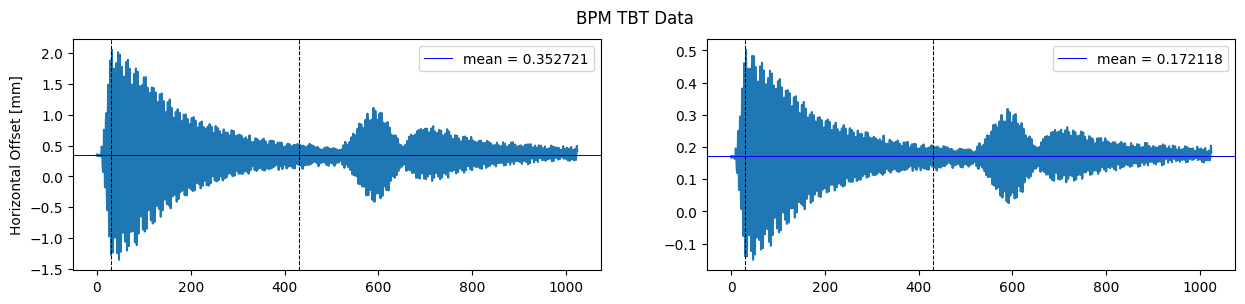

Correlation from bpm 1 & 2:
0.9296761150854789
0.9292860670928518



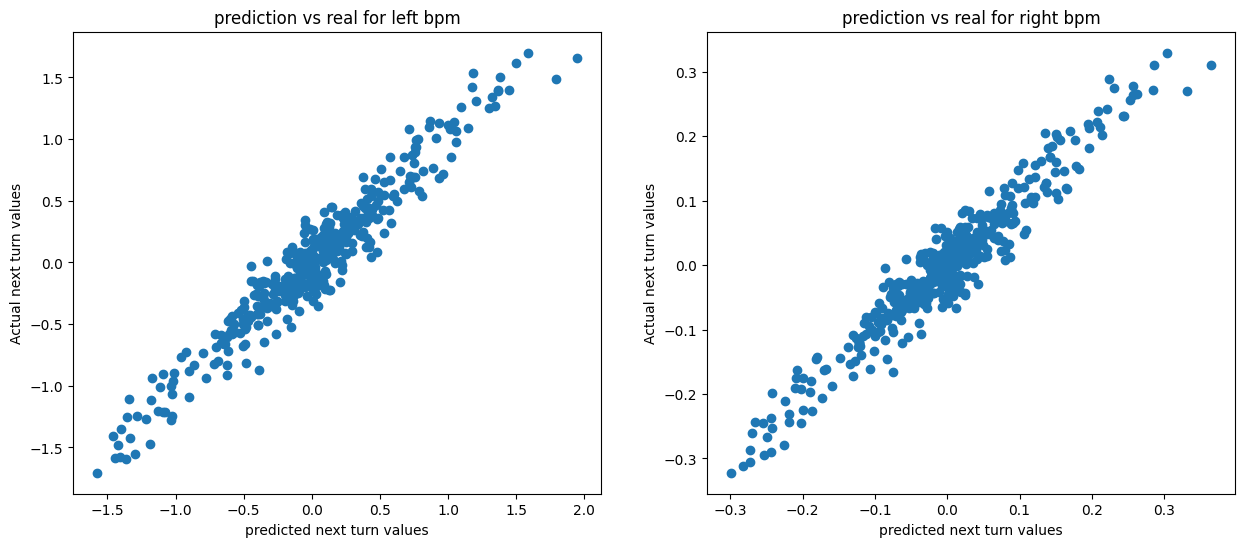


M:
[[  75.59751874 3379.93704622]
 [  -1.68741114  -75.43134269]]
determinant: 0.9210888688012029
determinant after normalization: 1.000000000000429
M after normalization:
[[  78.7692616  3521.7444943 ]
 [  -1.75820757  -78.59611353]]
M:
[[ 14.34595727 121.09889476]
 [ -1.68741114 -14.17978122]]
determinant: 0.9210888688029564
determinant after normalization: 0.9999999999999929
M after normalization:
[[ 14.9478512  126.17967733]
 [ -1.75820757 -14.77470312]]
Tune from bpm 1 & 2:
0.2362040438084
0.23620404380840343

Twiss:
[   1.48411378 3535.01699962 3535.01699962   78.9792214 ]
[  1.48411378 126.65521451 126.65521451  14.91728531]

Measured Beta for bpm 1, 2: 3535.016999615055 126.65521450953875
Model Beta for bpm 1, 2   : 1814.716854 65.47615064

beta beat at bpm 1, 2:
-0.9479716584012366
-0.9343717257587816


-----------------------------------------


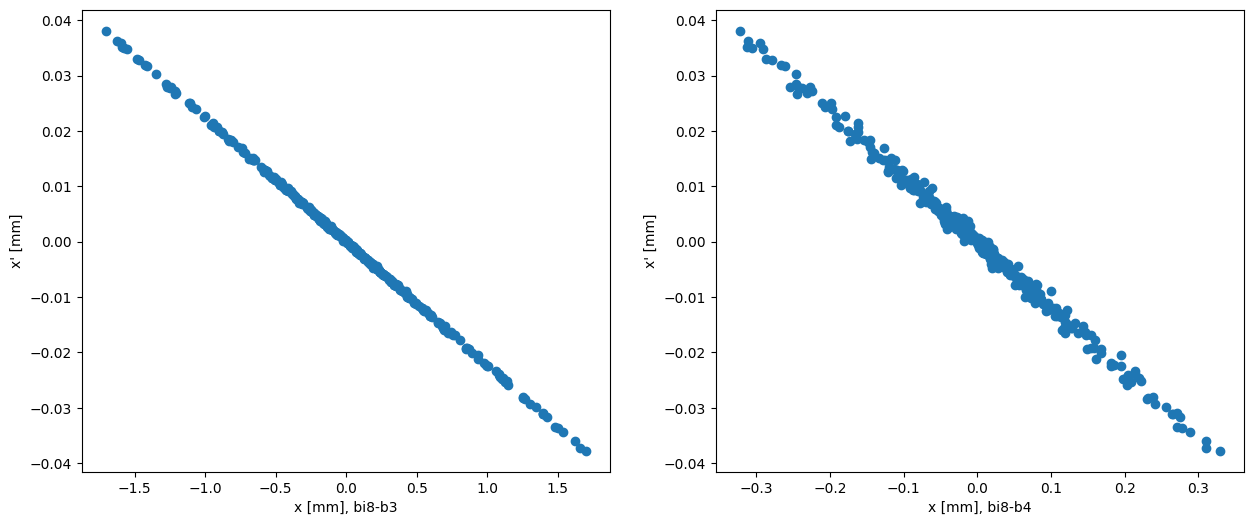

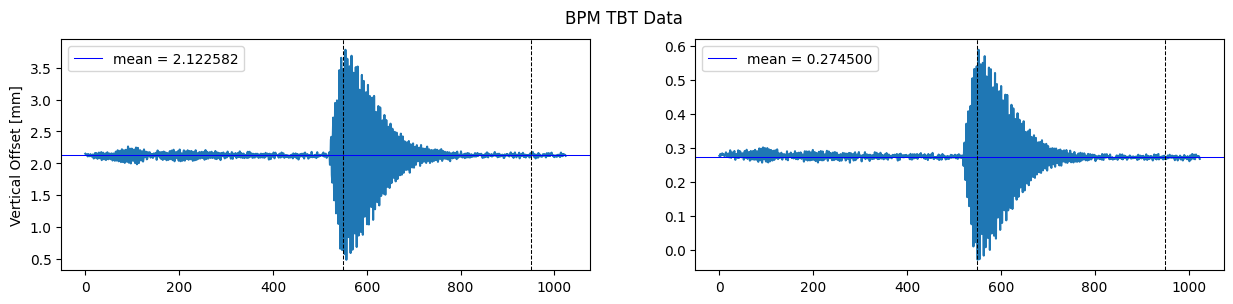

Correlation from bpm 1 & 2:
0.9767053839816252
0.9773366803598169



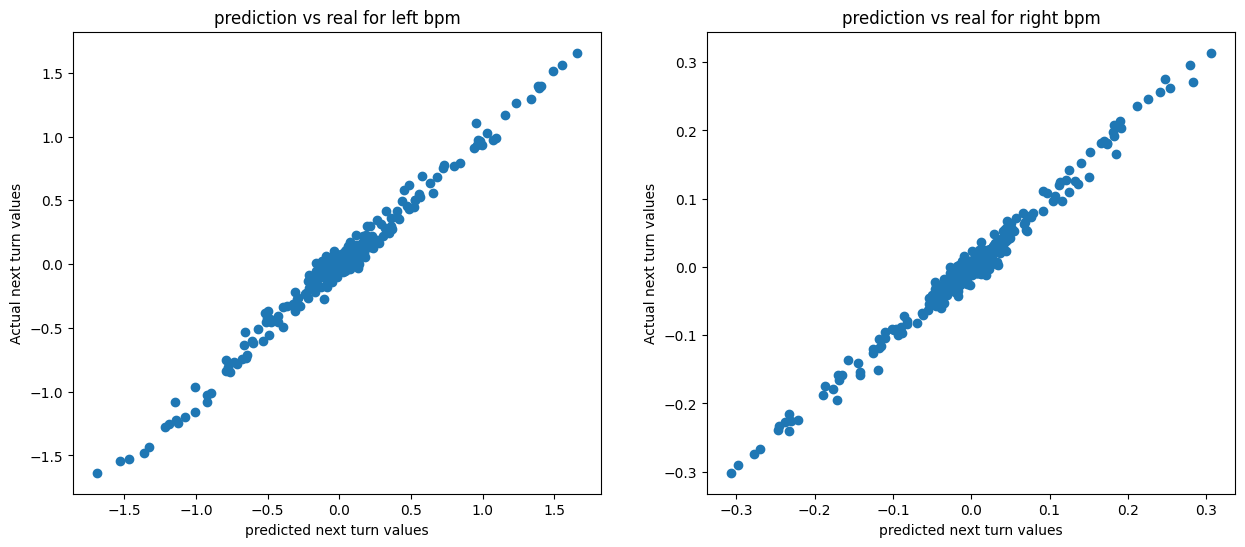


M:
[[ 17.94574837 550.20162572]
 [ -0.57867274 -17.68821736]]
determinant: 0.9583852005300292
determinant after normalization: 1.0000000000000488
M after normalization:
[[ 18.33122655 562.02006385]
 [ -0.59110274 -18.06816372]]
M:
[[-3.05957044 19.19442533]
 [-0.57867274  3.31710145]]
determinant: 0.9583852005299939
determinant after normalization: 0.9999999999999993
M after normalization:
[[-3.12529061 19.60672532]
 [-0.59110274  3.38835343]]
Tune from bpm 1 & 2:
0.22900528940616677
0.22900528940616557

Twiss:
[  1.43888267 566.94568629 566.94568629  18.35919981]
[ 1.43888267 19.77856141 19.77856141 -3.28536526]

Measured Beta for bpm 1, 2: 566.9456862858538 19.778561406674747
Model Beta for bpm 1, 2   : 649.6131896 20.29859581

beta beat at bpm 1, 2:
0.12725650377426742
0.025619230423271893


-----------------------------------------


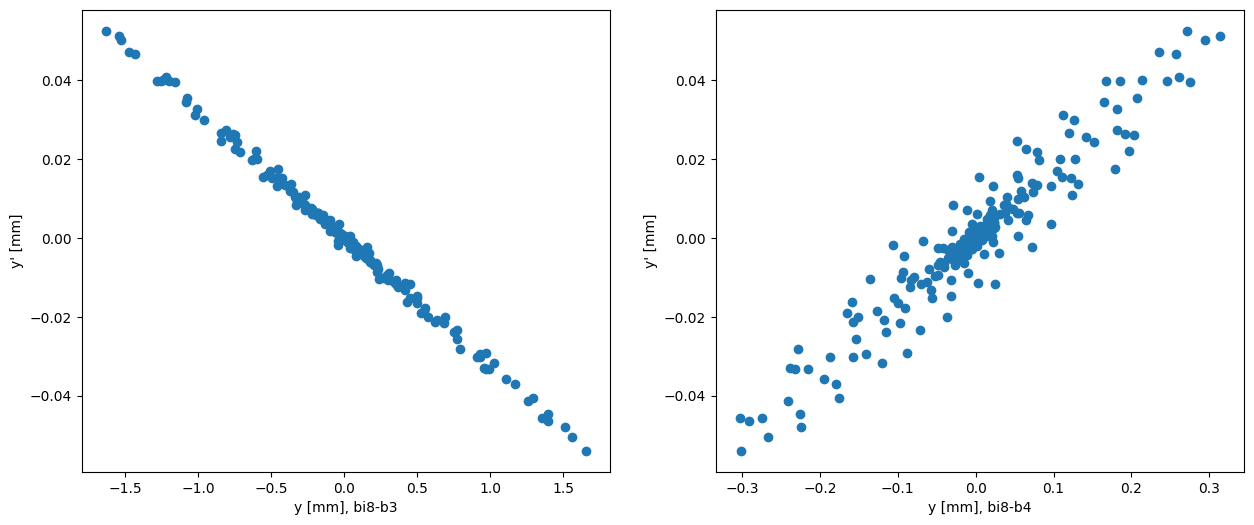

In [17]:
interval = 400
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 23, 25
Bpmsy = 24, 26
b_MADxx = [19.87322377, 661.517763]
b_MADxy = [62.79285429, 1770.202631]

# at IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 27, 28
Bpmsy = 28, 29
b_MADxx = [99.54348468, 98.44238123]
b_MADxy = [99.62958574, 98.73952675]

#upstream of IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 30, 32
b_MADxx = [1814.716854, 65.47615064] 
Bpmsy = 31, 33
b_MADxy = [649.6131896, 20.29859581]

bpm_signals(Bpmsx, BPMx, Intervalsx, True)
Twiss1x, Twiss2x = LR_calculation(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
# chrom(Interval_range, BPMx, S_xbpms, Bpmsx, b_MADxx, True)
# print("-----------------------------------------")
bpm_signals(Bpmsy, BPMy, Intervalsy, False)
Twiss1y, Twiss2y = LR_calculation(Intervalsy, BPMy, S_ybpms, Bpmsy, b_MADxy, Name_ybpms, False)
# chrom(Interval_range, BPMy, S_ybpms, Bpmsy, b_MADxy, False)

### Around IP10

Bad Horizontal BPMs: [50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 140]


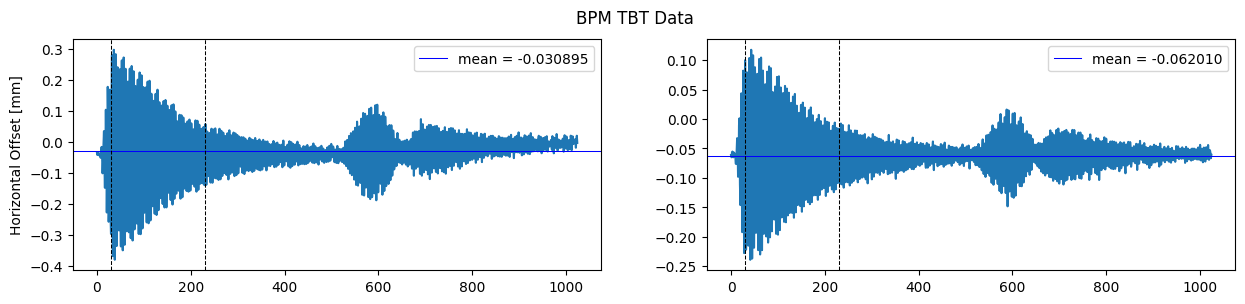

Correlation from bpm 1 & 2:
0.9944838986396698
0.9940314606120353



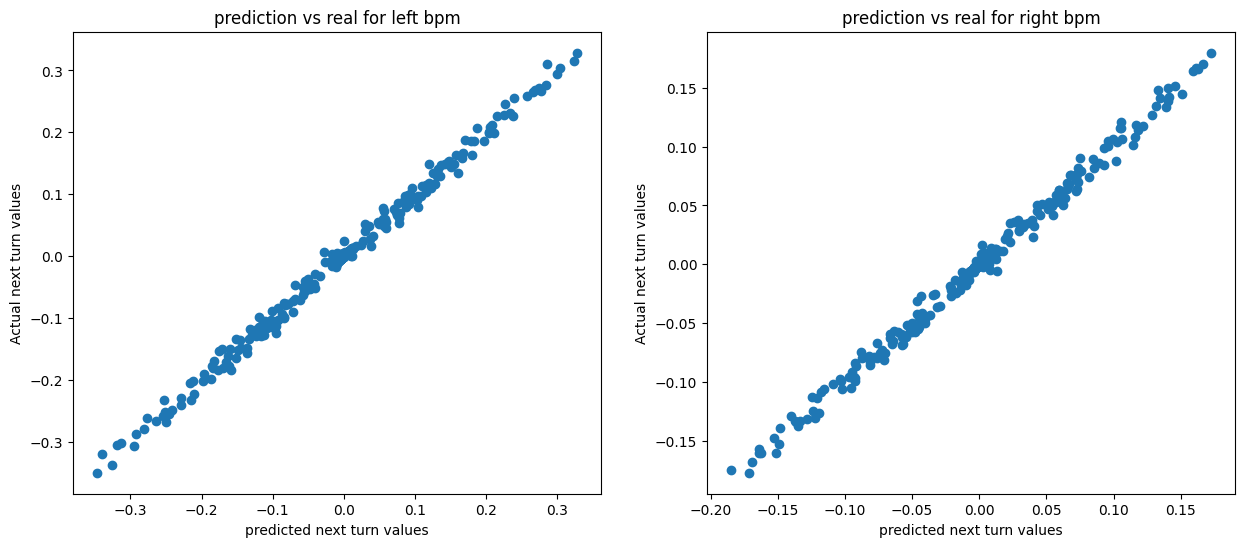


M:
[[ 3.02324352 80.85201817]
 [-0.11872704 -2.84938003]]
determinant: 0.9849510468391085
determinant after normalization: 1.0
M after normalization:
[[ 3.04625186 81.46734103]
 [-0.11963061 -2.87106519]]
M:
[[-1.28342312 24.04899834]
 [-0.11872704  1.45728661]]
determinant: 0.9849510468391119
determinant after normalization: 1.0
M after normalization:
[[-1.29319059 24.23202282]
 [-0.11963061  1.46837726]]
Tune from bpm 1 & 2:
0.2360411988245848
0.2360411988245851

Twiss:
[ 1.48309059 81.78168391 81.78168391  2.97007455]
[ 1.48309059 24.32552242 24.32552242 -1.3861117 ]

Measured Beta for bpm 1, 2: 81.78168390955582 24.325522420276965
Model Beta for bpm 1, 2   : 94.60224219 17.45850739

beta beat at bpm 1, 2:
0.13552065980312866
-0.393333454967078


-----------------------------------------


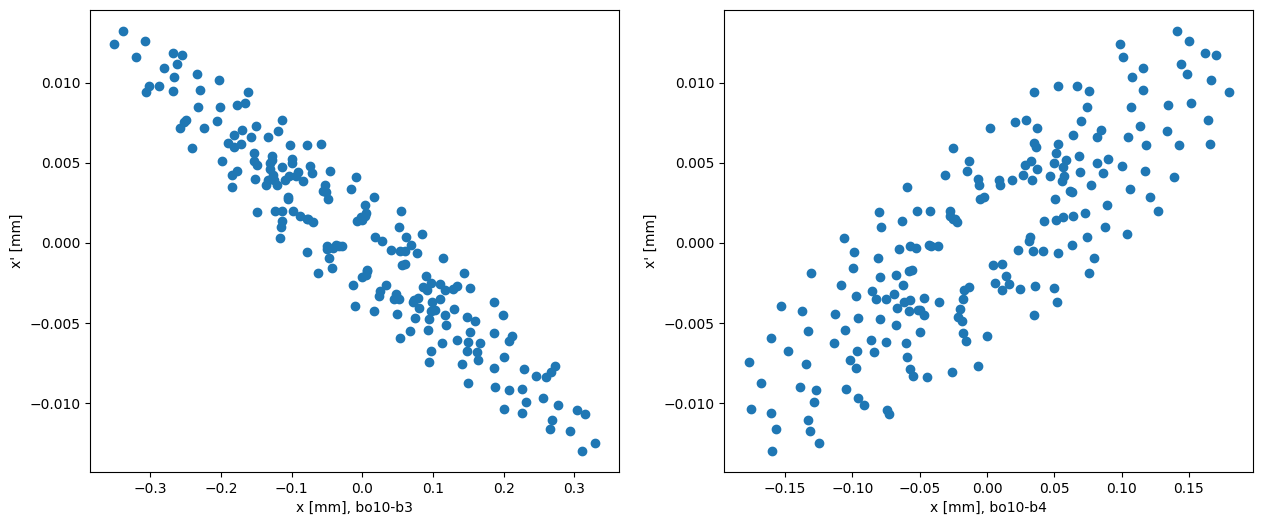

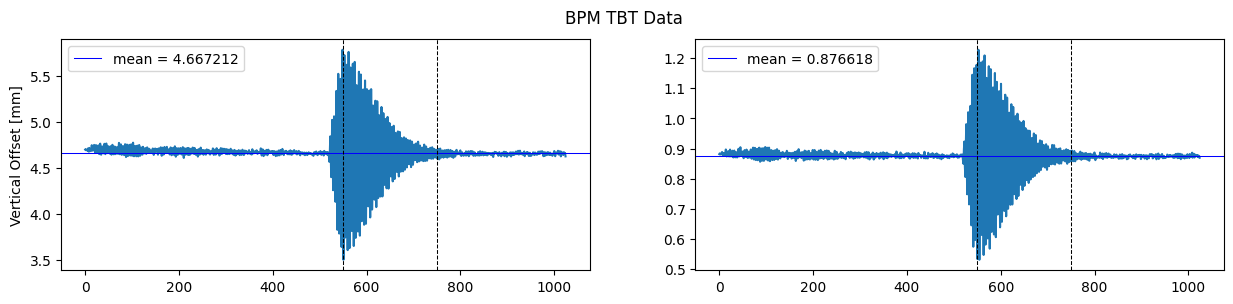

Correlation from bpm 1 & 2:
0.9951459957209072
0.9950944647471729



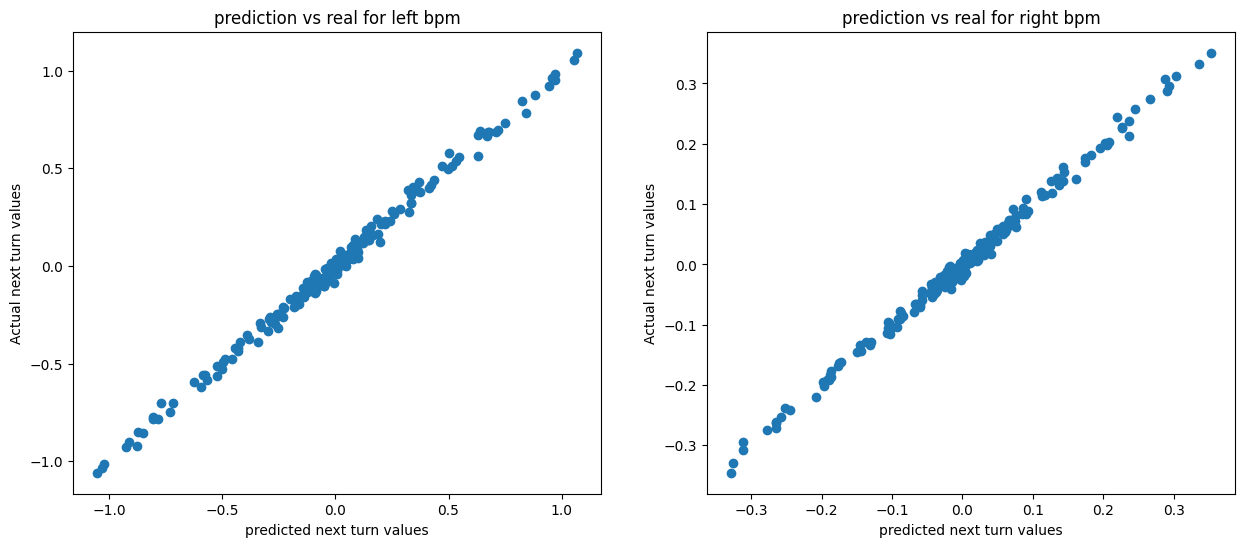


M:
[[  5.89933935 292.29129437]
 [ -0.11712871  -5.63795047]]
determinant: 0.9755196586722689
determinant after normalization: 0.9999999999999913
M after normalization:
[[  5.97290168 295.93604649]
 [ -0.11858926  -5.70825339]]
M:
[[ 1.65064995 27.90693521]
 [-0.11712871 -1.38926107]]
determinant: 0.975519658672265
determinant after normalization: 0.9999999999999999
M after normalization:
[[ 1.67123287 28.2549232 ]
 [-0.11858926 -1.40658458]]
Tune from bpm 1 & 2:
0.22887800965326222
0.22887800965326222

Twiss:
[  1.43808295 298.56144736 298.56144736   5.8923923 ]
[ 1.43808295 28.50558716 28.50558716  1.55256118]

Measured Beta for bpm 1, 2: 298.561447355419 28.505587156687312
Model Beta for bpm 1, 2   : 260.6868242 26.88939256

beta beat at bpm 1, 2:
-0.1452878306053605
-0.06010528475423883


-----------------------------------------


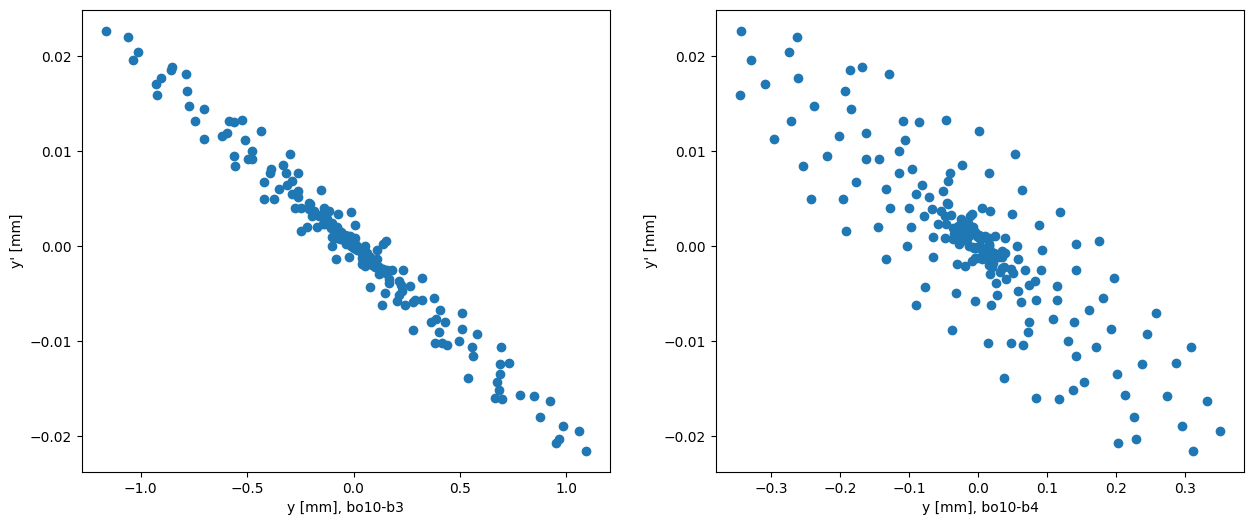

In [267]:
interval = 200
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP10
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 53, 55
Bpmsy = 53, 54
b_MADxx = [25.55882593, 259.1350568]
b_MADxy = [21.81527574, 92.99599271]

#at IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 57, 60
Bpmsy = 56, 59
b_MADxx = [18.85271553, 18.67088168]
b_MADxy = [18.70458023, 19.05146489]

#upstream of IP10
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 62, 64
b_MADxx = [94.60224219, 17.45850739] 
Bpmsy = 61, 63
b_MADxy = [260.6868242, 26.88939256]

# Interval_range = np.linspace(5, 200, 196)
bpm_signals(Bpmsx, BPMx, Intervalsx, True)
Twiss1x, Twiss2x = LR_calculation(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
# chrom2D(Interval_range, BPMx, S_xbpms, Bpmsx, b_MADxx, True)
# print("-----------------------------------------")
bpm_signals(Bpmsy, BPMy, Intervalsy, False)
Twiss1y, Twiss2y = LR_calculation(Intervalsy, BPMy, S_ybpms, Bpmsy, b_MADxy, Name_ybpms, False)
# chrom2D(Interval_range, BPMy, S_ybpms, Bpmsy, b_MADxy, False)

### Around IP12 

Bad Horizontal BPMs: [50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 140]


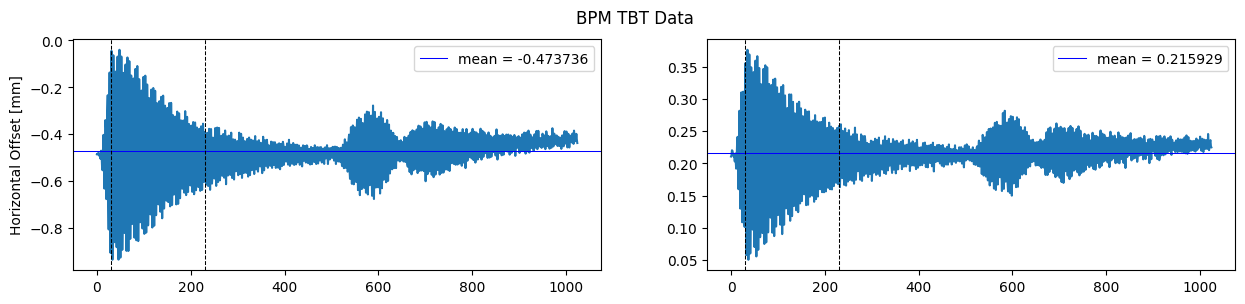

Correlation from bpm 1 & 2:
0.9925587367864782
0.9921435524903672



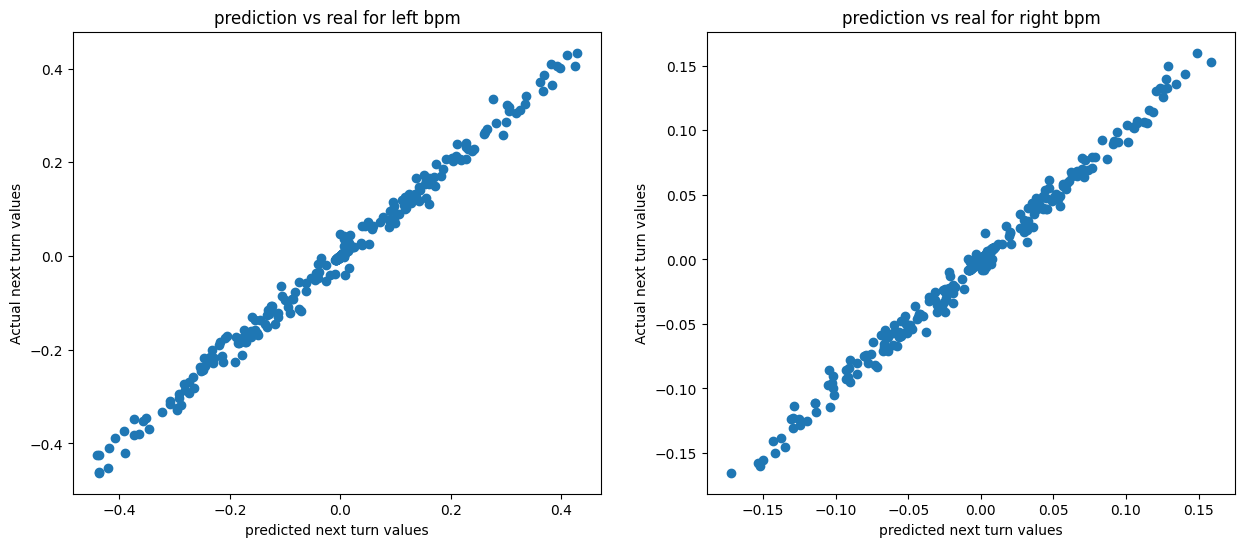


M:
[[  3.67916622 182.89923779]
 [ -0.07589563  -3.5057246 ]]
determinant: 0.9831091785363412
determinant after normalization: 0.9999999999999996
M after normalization:
[[  3.71063754 184.46374447]
 [ -0.07654483  -3.53571231]]
M:
[[ 0.92615246 22.13874754]
 [-0.07589563 -0.75271084]]
determinant: 0.983109178536341
determinant after normalization: 0.9999999999999998
M after normalization:
[[ 0.9340747  22.32812076]
 [-0.07654483 -0.75914947]]
Tune from bpm 1 & 2:
0.23606208406098292
0.23606208406098297

Twiss:
[  1.48322182 185.17336531 185.17336531   3.63711306]
[ 1.48322182 22.41401569 22.41401569  0.84986895]

Measured Beta for bpm 1, 2: 185.17336531123172 22.414015690782044
Model Beta for bpm 1, 2   : 259.7640288 26.73997493

beta beat at bpm 1, 2:
0.2871477772859684
0.16177873204976692


-----------------------------------------


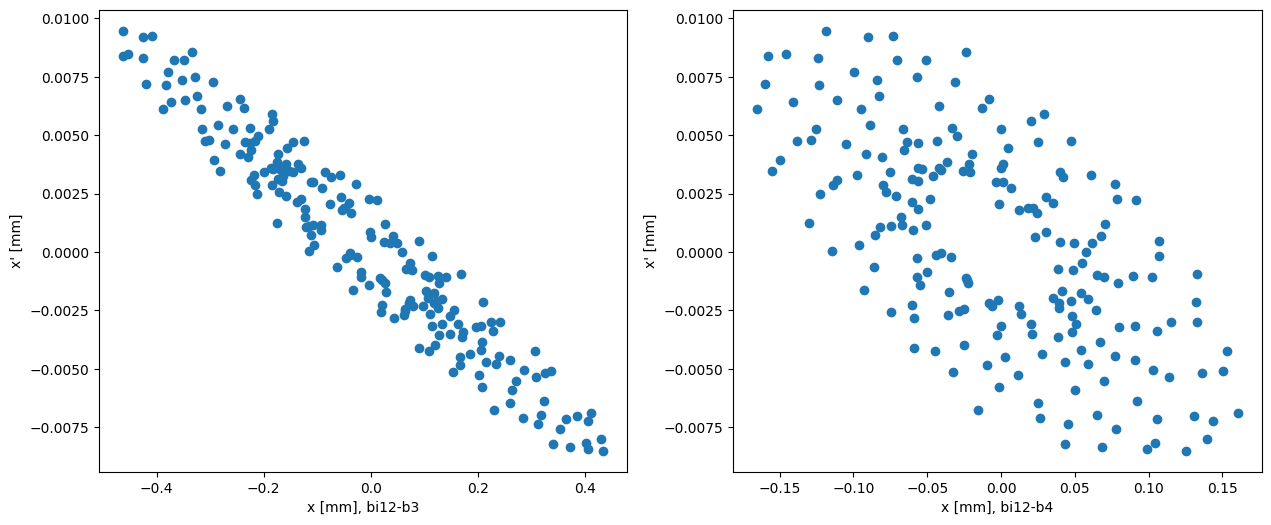

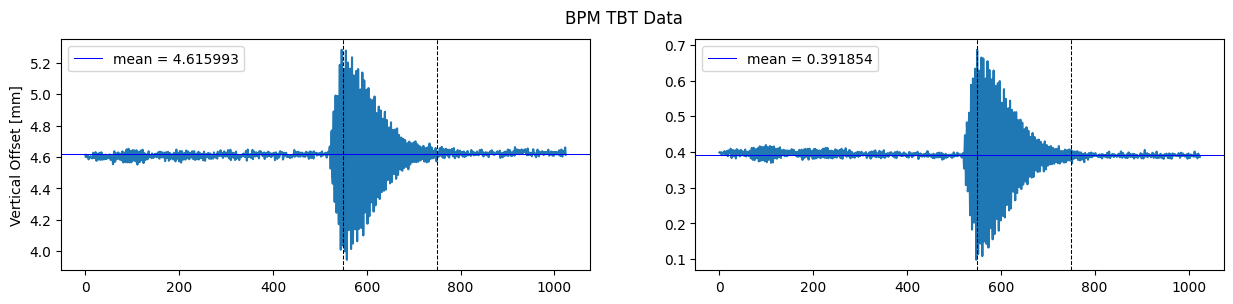

Correlation from bpm 1 & 2:
0.9953789483099347
0.9957779793119933



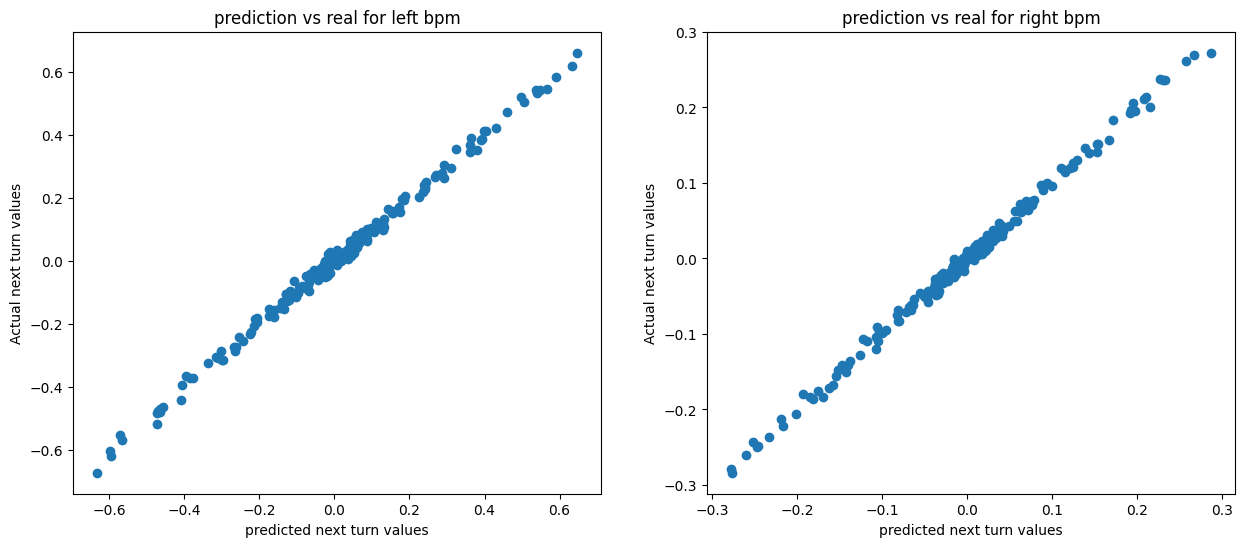


M:
[[ 3.44558456 96.68262606]
 [-0.1236084  -3.1850484 ]]
determinant: 0.9764315329430606
determinant after normalization: 0.9999999999999978
M after normalization:
[[ 3.48692025 97.84249979]
 [-0.1250913  -3.22325851]]
M:
[[-1.03814714 18.80661682]
 [-0.1236084   1.29868331]]
determinant: 0.9764315329430608
determinant after normalization: 0.9999999999999997
M after normalization:
[[-1.0506015  19.0322344 ]
 [-0.1250913   1.31426324]]
Tune from bpm 1 & 2:
0.22895721087487747
0.22895721087487736

Twiss:
[ 1.43858058 98.7039659  98.7039659   3.38462967]
[ 1.43858058 19.19980601 19.19980601 -1.19284324]

Measured Beta for bpm 1, 2: 98.70396590335942 19.19980601095433
Model Beta for bpm 1, 2   : 94.20459319 21.34783386

beta beat at bpm 1, 2:
-0.04776171268299727
0.10062041250332608


-----------------------------------------


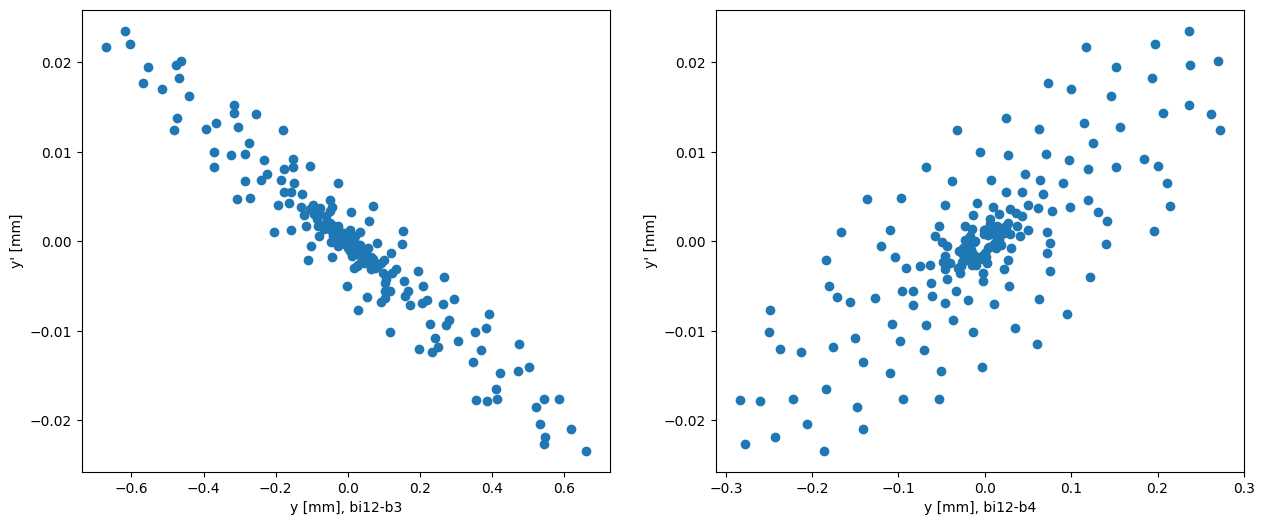

In [274]:
interval = 200
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP12
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 83, 84
Bpmsy = 83, 84
b_MADxx = [20.60080992, 94.79244064]
b_MADxy = [26.4804521, 261.2369843]

#at IP12
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 86, 87
Bpmsy = 86, 87
b_MADxx = [19.15235045, 18.63167495]
b_MADxy = [18.8909464, 18.91331833]

#upstream of IP12
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 89, 90
b_MADxx = [259.7640288, 26.73997493] 
Bpmsy = 89, 90
b_MADxy = [94.20459319, 21.34783386]

# Interval_range = np.linspace(5, 200, 196)
bpm_signals(Bpmsx, BPMx, Intervalsx, True)
Twiss1x, Twiss2x = LR_calculation(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
# chrom(Interval_range, BPMx, S_xbpms, Bpmsx, b_MADxx, True)
# print("-----------------------------------------")
bpm_signals(Bpmsy, BPMy, Intervalsy, False)
Twiss1y, Twiss2y = LR_calculation(Intervalsy, BPMy, S_ybpms, Bpmsy, b_MADxy, Name_ybpms, False)
# chrom(Interval_range, BPMy, S_ybpms, Bpmsy, b_MADxy, False)

## Excel stuff

In [102]:
with open('BPM LR Direct Measurement - 2D.csv') as datafile:
    datareader = csv.reader(datafile, delimiter=';')
    data = []
    for row in datareader:
        data_row = []
        Row = list(row[0].split(","))
        for col in Row:
            data_row.append(col)  
        data.append(np.array(data_row))
    data = np.array(data)
Regions = data.T[0, 2:14]

Corr_x_1 = (data.T[1, 2:14]).astype(float)
Corr_x_2 = (data.T[2, 2:14]).astype(float)
Corr_y_1 = (data.T[3, 2:14]).astype(float)
Corr_y_2 = (data.T[4, 2:14]).astype(float)

Det_x_1 = (data.T[5, 2:14]).astype(float)
Det_x_2 = (data.T[6, 2:14]).astype(float)
Det_y_1 = (data.T[7, 2:14]).astype(float)
Det_y_2 = (data.T[8, 2:14]).astype(float)

Tune_x_1 = (data.T[9, 2:14]).astype(float)
Tune_x_2 = (data.T[10, 2:14]).astype(float)
Tune_y_1 = (data.T[11, 3:14]).astype(float)
Tune_y_2 = (data.T[12, 3:14]).astype(float)

Beat_x_1 = (data.T[13, 3:14]).astype(float)
Beat_y_1 = (data.T[14, 2:14]).astype(float)
Beat_x_2 = (data.T[15, 3:14]).astype(float)
Beat_y_2 = (data.T[16, 2:14]).astype(float)


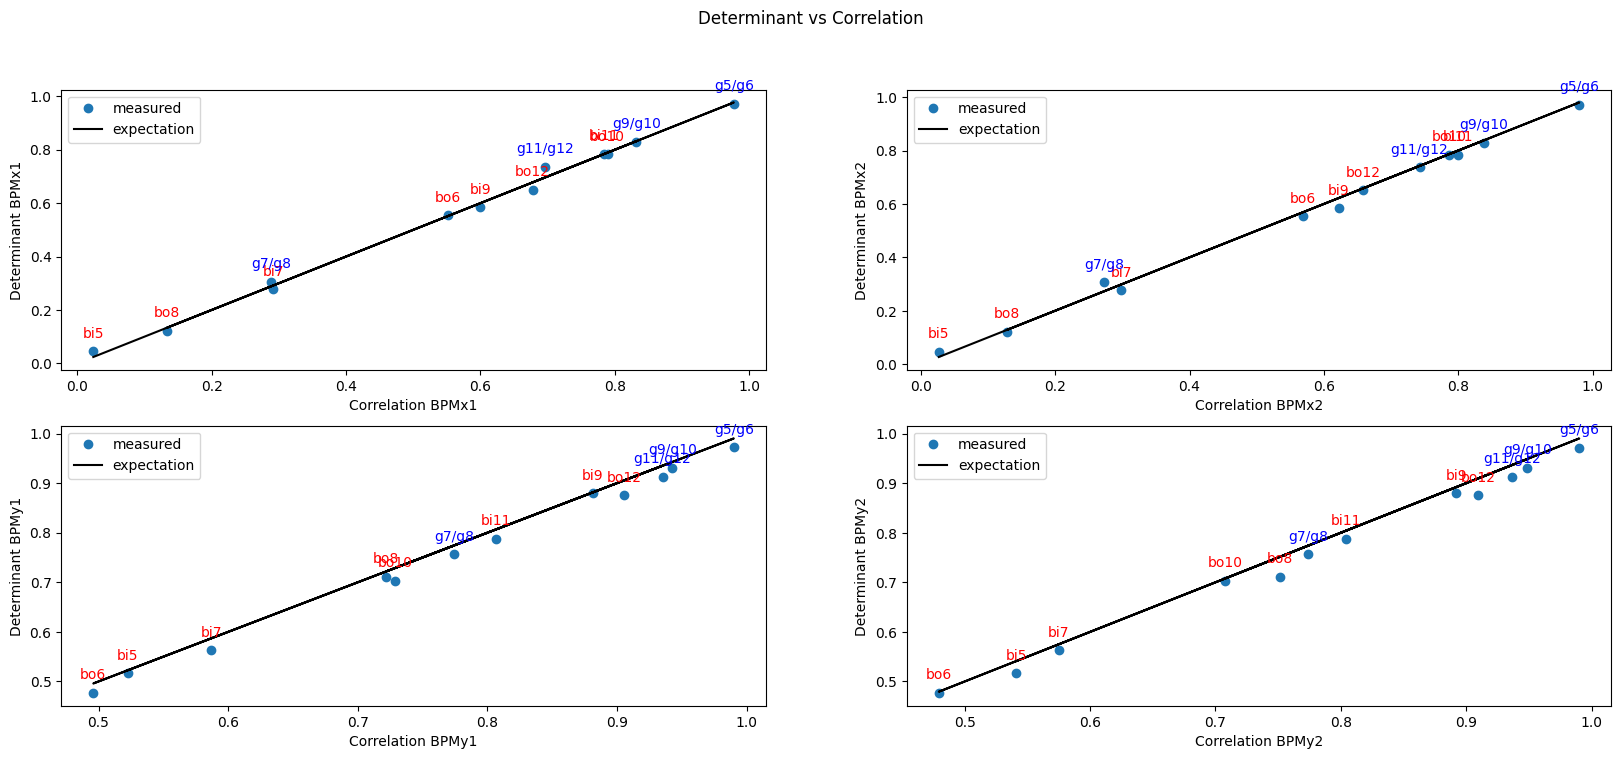

In [103]:
fig, Ax = plt.subplots(2, 2, figsize=(20, 8))
fig.suptitle("Determinant vs Correlation")
Ax[0][0].plot(Corr_x_1, Det_x_1, 'o', label = "measured")
Ax[0][0].plot(Corr_x_1, Corr_x_1, 'k', label = "expectation")
Ax[0][0].set_xlabel("Correlation BPMx1")
Ax[0][0].set_ylabel("Determinant BPMx1")


Ax[0][1].plot(Corr_x_2, Det_x_2, 'o', label = "measured")
Ax[0][1].plot(Corr_x_2, Corr_x_2, 'k', label = "expectation")
Ax[0][1].set_xlabel("Correlation BPMx2")
Ax[0][1].set_ylabel("Determinant BPMx2")

Ax[1][0].plot(Corr_y_1, Det_y_1, 'o', label = "measured")
Ax[1][0].plot(Corr_y_1, Corr_y_1, 'k', label = "expectation")
Ax[1][0].set_xlabel("Correlation BPMy1")
Ax[1][0].set_ylabel("Determinant BPMy1")

Ax[1][1].plot(Corr_y_2, Det_y_2, 'o', label = "measured")
Ax[1][1].plot(Corr_y_2, Corr_y_2, 'k', label = "expectation")
Ax[1][1].set_xlabel("Correlation BPMy2")
Ax[1][1].set_ylabel("Determinant BPMy2")
for i in range(2):
    for j in range(2):
        iter = 0
        for x, y, text in zip(data.T[1 + i*2 + j, 2:14], data.T[5 + i*2 + j, 2:14], Regions):
#             print(text, iter)
            if 'b' in text:
                if iter < 7: text = text[:3]
                elif iter >= 7: text = text[:4]
            if iter % 3 - 1 == 0: color = 'b'
            else: color = 'r'
            Ax[i][j].annotate(text, # this is the text
                (float(x),float(y)), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center',
                color = color) # horizontal alignment can be left, right or center
            iter += 1
        Ax[i][j].legend()
plt.show()

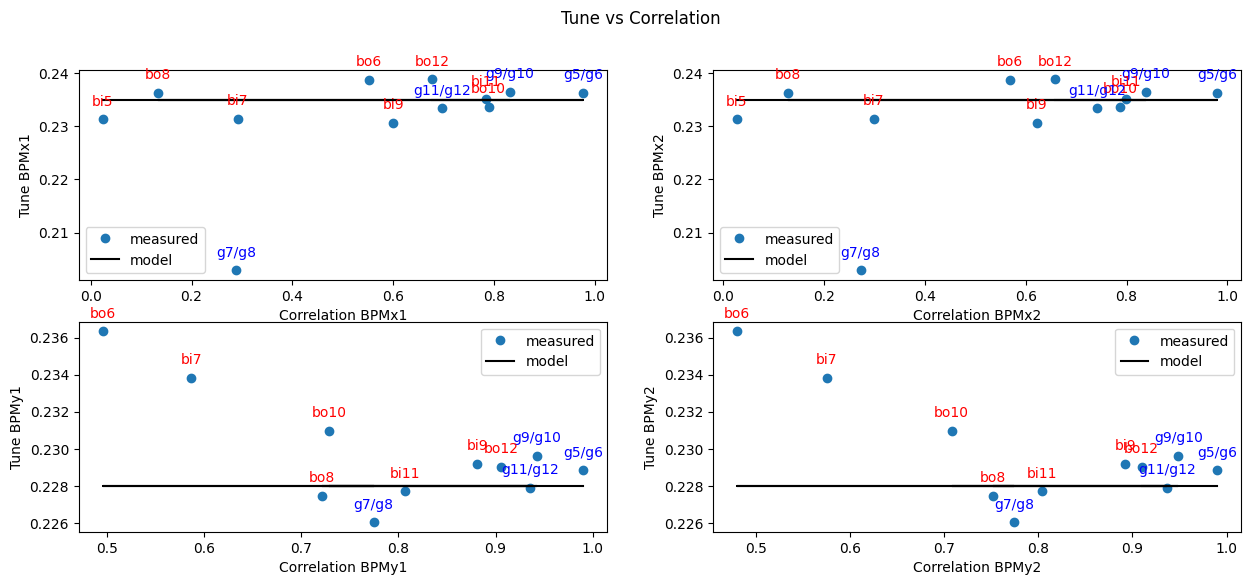

In [107]:
fig, Ax = plt.subplots(2, 2, figsize=(15, 6))
fig.suptitle("Tune vs Correlation")
Ax[0][0].plot(Corr_x_1, Tune_x_1, 'o', label = "measured")
Ax[0][0].plot(Corr_x_1, np.ones(12)*nu_x, 'k', label = "model")
Ax[0][0].set_xlabel("Correlation BPMx1")
Ax[0][0].set_ylabel("Tune BPMx1")

Ax[0][1].plot(Corr_x_2, Tune_x_2, 'o', label = "measured")
Ax[0][1].plot(Corr_x_2, np.ones(12)*nu_x, 'k', label = "model")
Ax[0][1].set_xlabel("Correlation BPMx2")
Ax[0][1].set_ylabel("Tune BPMx2")

Ax[1][0].plot(Corr_y_1[1:], Tune_y_1, 'o', label = "measured")
Ax[1][0].plot(Corr_y_1[1:], np.ones(11)*nu_y, 'k', label = "model")
Ax[1][0].set_xlabel("Correlation BPMy1")
Ax[1][0].set_ylabel("Tune BPMy1")

Ax[1][1].plot(Corr_y_2[1:], Tune_y_2, 'o', label = "measured")
Ax[1][1].plot(Corr_y_2[1:], np.ones(11)*nu_y, 'k', label = "model")
Ax[1][1].set_xlabel("Correlation BPMy2")
Ax[1][1].set_ylabel("Tune BPMy2")

for i in range(2):
    for j in range(2):
        iter = 0
        if i == 1:
            X = data.T[1 + i*2 + j, 3:14]
            Y = data.T[9 + i*2 + j, 3:14]
            Regions = data.T[0, 3:14]
        else: 
            X = data.T[1 + i*2 + j, 2:14]
            Y = data.T[9 + i*2 + j, 2:14]
            Regions = data.T[0, 2:14]
        for x, y, text in zip(X, Y, Regions):
            if 'b' in text:
                if iter < 7: text = text[:3]
                elif iter >= 7: text = text[:4]
            if i == 1:
                if iter % 3 == 0: color = 'b'
                else: color = 'r'
            else:
                if iter % 3 - 1 == 0: color = 'b'
                else: color = 'r'
            Ax[i][j].annotate(text, # this is the text
                (float(x),float(y)), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center',
                color = color) # horizontal alignment can be left, right or center
            iter += 1
        Ax[i][j].legend()
plt.show()

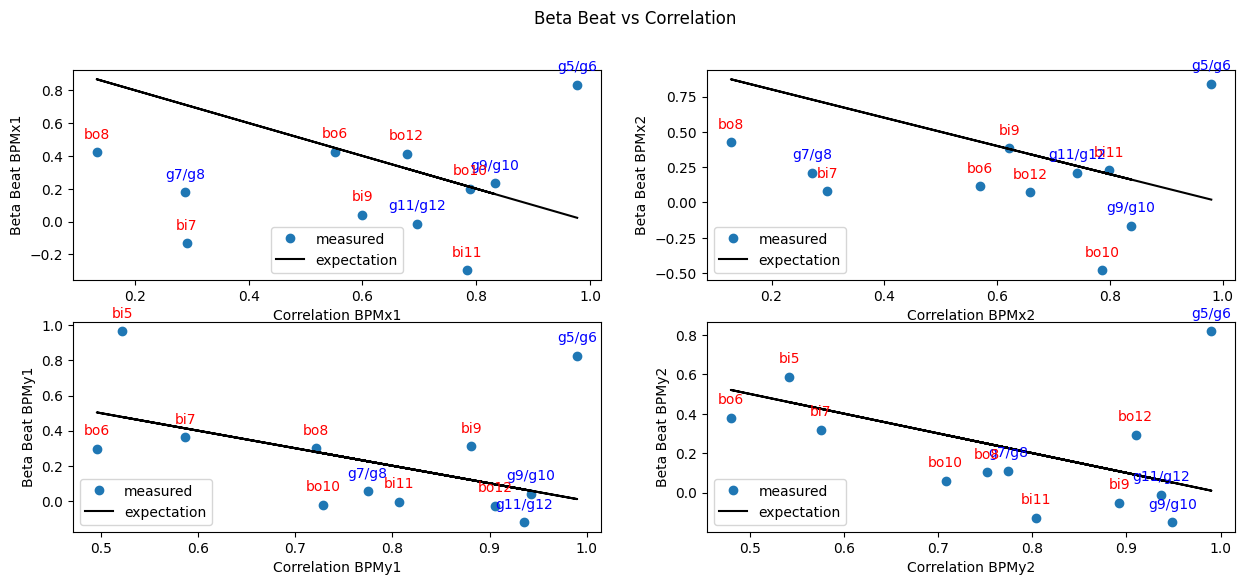

In [109]:
Regions = data.T[0, 2:14]
fig, Ax = plt.subplots(2, 2, figsize=(15, 6))
fig.suptitle("Beta Beat vs Correlation")
Ax[0][0].plot(Corr_x_1[1:], Beat_x_1, 'o', label = "measured")
Ax[0][0].plot(Corr_x_1[1:], 1 - Corr_x_1[1:], 'k', label = "expectation")
iter = 0
for x, y, text in zip(Corr_x_1[1:], Beat_x_1, Regions[1:]):
    if 'b' in text:
        if iter < 7: text = text[:3]
        elif iter >= 7: text = text[:4]
    if iter % 3 == 0: color = 'b'
    else: color = 'r'
    Ax[0][0].annotate(text, # this is the text
        (float(x),float(y)), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0,10), # distance from text to points (x,y)
        ha='center',
        color = color)
    iter += 1
Ax[0][0].set_xlabel("Correlation BPMx1")
Ax[0][0].set_ylabel("Beta Beat BPMx1")

Ax[0][1].plot(Corr_x_2[1:], Beat_x_2, 'o', label = "measured")
Ax[0][1].plot(Corr_x_2[1:], 1 - Corr_x_2[1:], 'k', label = "expectation")
iter = 0
for x, y, text in zip(Corr_x_2[1:], Beat_x_2, Regions[1:]):
    if 'b' in text:
        if iter < 7: text = text[:3]
        elif iter >= 7: text = text[:4]
    if iter % 3 == 0: color = 'b'
    else: color = 'r'
    Ax[0][1].annotate(text, # this is the text
        (float(x),float(y)), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0,10), # distance from text to points (x,y)
        ha='center',
        color = color)
    iter += 1
Ax[0][1].set_xlabel("Correlation BPMx2")
Ax[0][1].set_ylabel("Beta Beat BPMx2")

Ax[1][0].plot(Corr_y_1, Beat_y_1, 'o', label = "measured")
Ax[1][0].plot(Corr_y_1, 1 - Corr_y_1, 'k', label = "expectation")
iter = 0
for x, y, text in zip(Corr_y_1, Beat_y_1, Regions):
    if 'b' in text:
        if iter < 7: text = text[:3]
        elif iter >= 7: text = text[:4]
    if iter % 3 - 1 == 0: color = 'b'
    else: color = 'r'
    Ax[1][0].annotate(text, # this is the text
        (float(x),float(y)), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0,10), # distance from text to points (x,y)
        ha='center',
        color = color)
    iter += 1
Ax[1][0].set_xlabel("Correlation BPMy1")
Ax[1][0].set_ylabel("Beta Beat BPMy1")

Ax[1][1].plot(Corr_y_2, Beat_y_2, 'o', label = "measured")
Ax[1][1].plot(Corr_y_2, 1 - Corr_y_2, 'k', label = "expectation")
iter = 0
for x, y, text in zip(Corr_y_2, Beat_y_2, Regions):
    if 'b' in text:
        if iter < 7: text = text[:3]
        elif iter >= 7: text = text[:4]
    if iter % 3 - 1 == 0: color = 'b'
    else: color = 'r'
    Ax[1][1].annotate(text, # this is the text
        (float(x),float(y)), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0,10), # distance from text to points (x,y)
        ha='center',
        color = color)
    iter += 1
Ax[1][1].set_xlabel("Correlation BPMy2")
Ax[1][1].set_ylabel("Beta Beat BPMy2")
for i in range(2):
    for j in range(2):
        Ax[i][j].legend()
plt.show()

In [18]:
Namex = ['g6-bx', 'bo6-b1', 'bo6-b3', 'bo6-b3.1', 'bo6-b4', 'bo6-bh6', 'bo6-b7', 'bo6-b8', 'bo6-bh10', 'bo6-bh12', 'bo6-bh14', 'bo6-bh16', 'bo6-bh18', 'bo6-bh20', 'bo7-bh20', 'bo7-bh18', 'bo7-bh16', 'bo7-bh14', 'bo7-bh12', 'bo7-bh10', 'bo7-b8', 'bo7-b7', 'bo7-bh6', 'bo7-b4', 'bo7-b3.1', 'bo7-b3', 'bo7-b1', 'g7-bx', 'g8-bx', 'bi8-b1', 'bi8-b3', 'bi8-b3.1', 'bi8-b4', 'bi8-bh5', 'bi8-b7', 'bi8-b8', 'bi8-bh9', 'bi8-bh11', 'bi8-bh13', 'bi8-bh15', 'bi8-bh17', 'bi8-bh19', 'bi9-bh21', 'bi9-bh19', 'bi9-bh17', 'bi9-bh15', 'bi9-bh13', 'bi9-bh9', 'bi9-b7', 'bi9-bh5', 'bi9-b4', 'bi9-b3.1', 'bi9-b3', 'bi9-b1', 'g9-bx', 'g10-bx', 'bo10-b1', 'bo10-b3', 'bo10-b3.1', 'bo10-b4', 'bo10-bh6', 'bo10-b7', 'bo10-b8', 'bo10-bh10', 'bo10-bh12', 'bo10-bh14', 'bo10-bh18', 'bo10-bh20', 'bo11-bh20', 'bo11-bh18', 'bo11-bh16', 'bo11-bh14', 'bo11-bh12', 'bo11-bh10', 'bo11-b8', 'bo11-b7', 'bo11-bh6', 'bo11-b4', 'bo11-b3', 'bo11-b1', 'g11-bx', 'g12-bx', 'bi12-b1', 'bi12-b3', 'bi12-b4', 'bi12-bh5', 'bi12-b7', 'bi12-b8', 'bi12-bh9', 'bi12-bh11', 'bi12-bh13', 'bi12-bh15', 'bi12-bh17', 'bi12-bh19', 'bi1-bh21', 'bi1-bh19', 'bi1-bh13', 'bi1-bh11', 'bi1-bh9', 'bi1-b8', 'bi1-b7', 'bi1-bh5', 'bi1-b4', 'bi1-b3', 'bi1-b1', 'bo2-b1', 'bo2-b3', 'bo2-b4', 'bo2-bh6', 'bo2-b7', 'bo2-b8', 'bo2-bh10', 'bo2-bh14', 'bo2-bh16', 'bo2-bh18', 'bo2-bh20', 'bo3-bh20', 'bo3-bh18', 'bo3-bh16', 'bo3-bh14', 'bo3-bh12', 'bo3-bh10', 'bo3-b8', 'bo3-b7.1', 'bo3-b7', 'bo3-bh6', 'bo3-b4', 'bo3-b3', 'bo3-b1', 'bi4-b1', 'bi4-b4', 'bi4-bh5', 'bi4-b7', 'bi4-b8', 'bi4-bh9', 'bi4-bh11', 'bi4-bh13', 'bi4-bh15', 'bi4-bh17', 'bi4-bh19', 'bi5-bh21', 'bi5-bh19', 'bi5-bh17', 'bi5-bh15', 'bi5-bh13', 'bi5-bh11', 'bi5-bh9', 'bi5-b8', 'bi5-b7', 'bi5-bh5', 'bi5-b4', 'bi5-b3.1', 'bi5-b3', 'bi5-b1', 'g5-bx']


Beatx = np.array([-0.071, -0.062, -0.1, -0.234, 0.104, -0.236, 0.17, 0.15, 
          -0.202, 0.199, -0.217, 0.201, -0.215, 0.165, -0.058, 0.021, 
          0.021, -0.093, 0.079, -0.195, 0.209, -0.083, -0.134, 0.243, 
          0.115, 0.125, 0.128, 0.167, 0.148, 0.11, -0.097, 0.16, 0.144, 
          0.105, -0.043, 0.083, 0.105, -0.076, 0.099, -0.052, 0.017, 0.017, 
          -0.014, 0.092, -0.179, 0.182, -0.131, -0.12, 0.043, 0.089, 0.045, 
          -0.082, -0.048, -0.175, -0.139, 0.069, -0.034, -0.074, -0.142, 0.198, 
          -0.195, 0.055, 0.175, -0.137, 0.098, 0.002, 0.047, -0.122, 0.114, -0.134, 
          0.162, -0.202, 0.138, -0.164, 0.129, 0.116, -0.028, 0.163, -0.156, 
          -0.159, -0.019, -0.194, -0.187, -0.186, -0.147, -0.047, 0.202, 0.098, 
          -0.184, 0.145, -0.162, 0.1, -0.028, -0.008, 0.085, -0.101, 0.169, 
          -0.188, 0.136, 0.055, -0.086, -0.074, -0.052, 0.131, 0.127, 0.04, 
          0.087, -0.168, -0.088, -0.161, -0.063, 0.038, 0.085, -0.162, 0.112, 
          -0.168, 0.128, -0.159, 0.04, -0.088, 0.025, -0.012, -0.061, 0.027, 
          0.032, 0.06, 0.034, -0.16, -0.206, -0.159, -0.208, -0.173, 0.089, 
          0.113, -0.125, 0.055, -0.077, 0.01, 0.052, -0.109, 0.076, -0.145, 0.099, 
          -0.175, 0.1, -0.183, 0.048, 0.197, -0.135, -0.153, -0.108, -0.072, -0.059, 
          -0.057, -0.083])
# print(np.mean(np.abs(Beatx)))

# print(Namex[-1], Namex[0], Namex[27], Namex[28], Namex[54], Namex[55], Namex[80], Namex[81])
# Beatxs = np.array([Beatx[-1], Beatx[0], Beatx[27], Beatx[28], Beatx[54], Beatx[55], Beatx[80], Beatx[81]])
# print(Beatxs)
# print(np.mean(np.abs(Beatxs)))

# print(Namex[-5], Namex[-3], 
#       Namex[2], Namex[4], 
#       Namex[23], Namex[25], 
#       Namex[30], Namex[32])
# print(np.array([Beatx[-5], Beatx[-3],
#                 Beatx[2], Beatx[4],
#                 Beatx[23], Beatx[25],
#                 Beatx[30], Beatx[32],
#                ]))

# print(Namex[50], Namex[52], 
#       Namex[57], Namex[59], 
#       Namex[77], Namex[78], 
#       Namex[83], Namex[84])
# print(np.array([Beatx[50], Beatx[52],
#                 Beatx[57], Beatx[59],
#                 Beatx[77], Beatx[78],
#                 Beatx[83], Beatx[84],
#                ]))

bi5-b4 bi5-b3 bo6-b3 bo6-b4 bo7-b4 bo7-b3 bi8-b3 bi8-b4
[-0.108 -0.059 -0.1    0.104  0.243  0.125 -0.097  0.144]
bi9-b4 bi9-b3 bo10-b3 bo10-b4 bo11-b4 bo11-b3 bi12-b3 bi12-b4
[ 0.045 -0.048 -0.074  0.198  0.163 -0.156 -0.186 -0.147]


In [30]:
Namey = np.array(['g6-bx', 'bo6-b1', 'bo6-b3', 'bo6-b3.1', 'bo6-b4', 'bo6-bv5', 'bo6-b7', 'bo6-b8', 'bo6-bv9', 'bo6-bv13', 'bo6-bv15', 'bo6-bv17', 'bo6-bv19', 'bo7-bv21', 'bo7-bv19', 'bo7-bv17', 'bo7-bv15', 'bo7-bv13', 'bo7-bv11', 'bo7-bv9', 'bo7-b8', 'bo7-b7', 'bo7-bv5', 'bo7-b4', 'bo7-b3.1', 'bo7-b3', 'g7-bx', 'g8-bx', 'bi8-b1', 'bi8-b3', 'bi8-b3.1', 'bi8-b4', 'bi8-bv6', 'bi8-b7', 'bi8-b8', 'bi8-bv10', 'bi8-bv12', 'bi8-bv14', 'bi8-bv16', 'bi8-bv18', 'bi8-bv20', 'bi9-bv20', 'bi9-bv18', 'bi9-bv16', 'bi9-bv14', 'bi9-bv12', 'bi9-bv10', 'bi9-b8', 'bi9-bv6', 'bi9-b4', 'bi9-b3', 'bi9-b1', 'g9-bx', 'g10-bx', 'bo10-b1', 'bo10-b3', 'bo10-b4', 'bo10-bv5', 'bo10-b7', 'bo10-b8', 'bo10-bv9', 'bo10-bv11', 'bo10-bv13', 'bo10-bv15', 'bo10-bv17', 'bo10-bv19', 'bo11-bv21', 'bo11-bv19', 'bo11-bv17', 'bo11-bv15', 'bo11-bv13', 'bo11-bv11', 'bo11-bv9', 'bo11-b8', 'bo11-b7', 'bo11-bv5', 'bo11-b4', 'bo11-b3', 'bo11-b1', 'g11-bx', 'g12-bx', 'bi12-b1', 'bi12-b3', 'bi12-b4', 'bi12-bv6', 'bi12-b7', 'bi12-b8', 'bi12-bv10', 'bi12-bv12', 'bi12-bv14', 'bi12-bv16', 'bi12-bv18', 'bi12-bv20', 'bi1-bv20', 'bi1-bv18', 'bi1-bv16', 'bi1-bv14', 'bi1-bv12', 'bi1-bv10', 'bi1-b8', 'bi1-b7', 'bi1-bv6', 'bi1-b4', 'bi1-b3', 'bo2-b1', 'bo2-b3', 'bo2-b4', 'bo2-bv5', 'bo2-b7', 'bo2-bv9', 'bo2-bv11', 'bo2-bv13', 'bo2-bv15', 'bo2-bv17', 'bo3-bv21', 'bo3-bv19', 'bo3-bv17', 'bo3-bv15', 'bo3-bv13', 'bo3-bv11', 'bo3-bv9', 'bo3-b8', 'bo3-b7.1', 'bo3-b7', 'bo3-bv5', 'bo3-b4', 'bo3-b3', 'bo3-b1', 'bi4-b1', 'bi4-b3', 'bi4-b4', 'bi4-bv6', 'bi4-b7', 'bi4-b8', 'bi4-bv10', 'bi4-bv12', 'bi4-bv14', 'bi4-bv16', 'bi4-bv18', 'bi4-bv20', 'bi5-bv20', 'bi5-bv18', 'bi5-bv16', 'bi5-bv14', 'bi5-bv12', 'bi5-bv10', 'bi5-b8', 'bi5-b7', 'bi5-bv6', 'bi5-b4', 'bi5-b3.1', 'bi5-b3', 'bi5-b1', 'g5-bx'])
Beaty = np.array([0.152, 0.144, 0.143, 0.182, 0.084, -0.027, -0.258, 0.07, 0.286, 0.322, -0.23, 0.33, -0.201, 0.312, -0.209, 0.267, -0.16, 0.249, -0.105, 0.183, 0.125, -0.157, -0.13, -0.053, 0.015, 0.005, -0.001, -0.03, -0.008, -0.039, 0.307, 0.059, -0.04, 0.124, 0.033, -0.014, 0.071, -0.029, 0.073, -0.035, 0.076, -0.052, 0.048, -0.038, 0.001, -0.056, 0.014, -0.033, 0.016, -0.124, 0.021, 0.01, -0.028, 0.045, 0.05, 0.035, -0.023, -0.047, 0.013, 0.034, -0.008, -0.079, 0.036, -0.087, 0.036, -0.113, 0.047, -0.128, 0.047, -0.116, 0.033, -0.1, 0.023, -0.079, -0.1, -0.083, -0.003, 0.046, 0.041, 0.028, -0.043, 0.027, 0.016, -0.121, -0.029, -0.061, -0.091, 0.006, -0.099, 0.046, -0.1, 0.033, -0.144, 0.065, -0.116, 0.04, -0.115, 0.064, -0.127, 0.028, 0.056, -0.1, 0.043, -0.075, -0.039, -0.046, 0.01, -0.005, 0.013, -0.055, 0.039, -0.096, 0.034, -0.081, -0.072, 0.036, -0.07, 0.024, -0.06, -0.025, -0.036, -0.04, -0.077, -0.001, 0.017, 0.016, -0.022, -0.034, 0.004, 0.021, 0.175, -0.152, 0.179, 0.097, -0.143, 0.136, -0.151, 0.108, -0.164, 0.14, -0.151, 0.122, -0.134, 0.104, -0.1, 0.064, -0.027, -0.214, 0.099, 0.068, -0.023, 0.117, 0.104, 0.087])

# print(Namey[-1], Namey[0], Namey[26], Namey[27], Namey[52], Namey[53], Namey[79], Namey[80])
# Beatys = np.array([Beaty[-1], Beaty[0], Beaty[26], Beaty[27], Beaty[52], Beaty[53], Beaty[79], Beaty[80]])
# print(Beatys)
# print(np.mean(np.abs(Beatys)))

print(Namey[-5], Namey[-3], 
      Namey[2], Namey[4], 
      Namey[23], Namey[25], 
      Namey[29], Namey[31])
print(np.array([Beaty[-5], Beaty[-3],
                Beaty[2], Beaty[4],
                Beaty[23], Beaty[25],
                Beaty[29], Beaty[31],
               ]))

print(Namey[49], Namey[50], 
      Namey[55], Namey[56], 
      Namey[76], Namey[77], 
      Namey[82], Namey[83])
print(np.array([Beaty[49], Beaty[50],
                Beaty[55], Beaty[56],
                Beaty[76], Beaty[77],
                Beaty[82], Beaty[83],
               ]))

bi5-b4 bi5-b3 bo6-b3 bo6-b4 bo7-b4 bo7-b3 bi8-b3 bi8-b4
[ 0.068  0.117  0.143  0.084 -0.053  0.005 -0.039  0.059]
bi9-b4 bi9-b3 bo10-b3 bo10-b4 bo11-b4 bo11-b3 bi12-b3 bi12-b4
[-0.124  0.021  0.035 -0.023 -0.003  0.046  0.016 -0.121]


In [45]:
print(Namex[:5])
Ampx = np.array([9.023976378960526, 28.378342935055247, 23.45524075014573, 1.1728128040088968, 5.1990823710639456, 4.636546549626163, 3.212443039979198, 8.29929908615073, 5.170736614063624, 8.075719813926137, 5.141260431381708, 7.969447167507482, 5.2342771669209665, 7.623905183309108, 6.351364528391834, 6.622676635503028, 6.925927208181487, 5.853820055354692, 7.333044674840639, 5.208029168327938, 8.64735445352615, 2.546102418456038, 5.261900162278187, 5.631145911448115, 1.8029519835907175, 29.04899064631257, 33.863676006109884, 11.710650314367419, 11.501443839849447, 33.329017671291545, 38.61589551341023, 16.64233416358255, 9.286281414847547, 10.265168178238765, 6.752631662949212, 2.968236824871872, 7.351076212186709, 6.076181246265699, 7.316400621537624, 6.234744088716372, 6.761932876806288, 6.699248734280576, 6.536813652353471, 7.226557223050035, 5.424937187398135, 7.833484687638663, 5.7315293698961, 5.785079202363325, 7.273260559633373, 8.15405418257714, 5.258577586183656, 11.860122402932166, 15.233799258913653, 9.314204913048844, 3.724865174147417, 4.614001405799031, 10.900592021278001, 8.955831474561155, 4.426893074345631, 5.049579237118893, 5.1161084308176665, 3.8733427151719795, 8.106265688094023, 5.578967346943277, 7.424945780561491, 6.543419127047179, 6.9265006751936635, 5.793190070918751, 7.466106606999773, 5.646032919673291, 7.86269688092428, 5.164135677609908, 7.726411648968085, 5.4015623907756485, 7.824239668622422, 4.028412827489309, 6.064672528477941, 5.324980520590109, 8.195348689718784, 9.624350620673694, 4.312743134457594, 3.4483896031508428, 9.198482636727626, 13.033139469826587, 4.413428643315089, 7.359681096845057, 8.276906817783118, 3.74195088012544, 5.362235203194786, 7.643127366358266, 5.481516603487488, 7.389636337726958, 6.3223104950352695, 6.6726484515091595, 7.058803562257277, 6.036329543388645, 7.728216375341651, 5.360612976699429, 7.582589553430423, 3.5717991106414084, 6.228157228817271, 7.53395840855897, 5.099959874591834, 18.41967467920147, 12.978103550120837, 12.04704105350789, 10.543088288815731, 4.543548091158516, 5.447610525799422, 2.832634186010278, 6.5206171523362, 6.73555049223264, 7.1114594709034975, 5.577823667542349, 7.380437631453646, 5.464702327779948, 7.565805478266486, 5.470960429391322, 7.01477886224715, 5.907455299872768, 6.93177838025907, 6.407515523204508, 6.494023739236695, 5.203069481304707, 3.69482879959319, 6.5833353240020775, 4.832065345390432, 8.103165489623223, 9.032995118146378, 9.481188349308974, 4.12372218684516, 6.462390318947858, 7.559830781510303, 3.802547754194591, 5.720742471137043, 7.064622355575964, 6.010198359701637, 6.779240858354518, 6.848521258131955, 5.978691567758128, 7.04441604272155, 5.681434813349127, 7.2537676935485065, 5.438851154818381, 7.317879999177401, 5.363991792272597, 7.011981909816101, 3.2575663323371042, 6.091119866047139, 8.185441358915165, 7.403713133938644, 13.528631500343069, 40.602450758563876, 28.55428733957392, 9.258420834688396])
Ampmx = np.array([9.711520337635612, 30.266591077196452, 26.063050621694497, 1.5316146511983195, 4.707308502183748, 6.068888056469644, 2.746116699619603, 7.21535229855152, 6.478034835302493, 6.737152396545903, 6.569394289170829, 6.637921114507124, 6.670007037714376, 6.546773064871265, 6.740687232363092, 6.4865765954477945, 6.781876423989684, 6.455103957251362, 6.795361244210671, 6.469244900187433, 7.153885237982882, 2.7770515262004, 6.075874081029445, 4.530054469307903, 1.6171301828056517, 25.832432949855903, 30.033187560982167, 10.034605682823665, 10.016992103753003, 30.02103074955289, 42.770861760580416, 14.35277441859493, 8.114673232099344, 9.288296708447296, 7.057418971434117, 2.7408805055778096, 6.651454501310702, 6.576252037913306, 6.657853557621188, 6.579214990123784, 6.647677130182753, 6.589203454974076, 6.62928395917544, 6.615358758217494, 6.60708665215106, 6.629569873022405, 6.592489314937174, 6.570628130453405, 6.974625059569747, 7.487332263427128, 5.033606629769345, 12.917486707916677, 15.996498681487365, 11.29151026271309, 4.3245053253865, 4.315711537278181, 11.278692404566453, 9.667456355529344, 5.158806884950095, 4.214898698341231, 6.356004478012, 3.670398779586273, 6.89983645550721, 6.467508902033432, 6.763646650693545, 6.533298869255324, 6.616635310903526, 6.5981285498227376, 6.702910267344909, 6.522183250833221, 6.76656056686209, 6.467490463768216, 6.791832447373824, 6.458784125423229, 6.928401996599858, 3.6094104489325263, 6.238185249922128, 4.580263533697673, 9.710174501871993, 11.438570564165568, 4.396356061873128, 4.277641553348539, 11.309354222966446, 16.01416543131168, 5.176457063518647, 7.725615680911017, 6.885387164912326, 3.40891422444662, 6.571386284573218, 6.674657608911652, 6.53846328140476, 6.717244310997122, 6.507119693035859, 6.726585540015789, 6.50468722892902, 6.714710505344255, 6.613027845740497, 6.605623981994138, 6.67553441291037, 3.3851908573411045, 6.814625778662208, 8.134309006588403, 5.3781751987054776, 16.28614809282597, 11.517997682254107, 11.586429746392673, 9.696618207010143, 5.459000445852711, 5.9744096442805965, 3.3774175355792035, 6.956260745182178, 6.488085853667721, 6.555789596874789, 6.656705577860711, 6.638787909977174, 6.568363628839865, 6.706458798418738, 6.509102736359167, 6.747204047607787, 6.47948351201117, 6.7631475919517685, 6.48452743500371, 6.915749647706689, 5.066324668289726, 3.580857223111332, 6.211380671275019, 4.671089917384839, 9.641406537921394, 11.37445981135192, 11.271555340424053, 5.20901006770248, 7.817128963702748, 6.9443082399446885, 3.4162011923954068, 6.5369369419877765, 6.697933102308525, 6.513048412049123, 6.714041386869089, 6.511830006453347, 6.706435401736663, 6.544807880375229, 6.645241401621344, 6.6016775130179, 6.59139451397606, 6.651458907616652, 6.563350636942217, 6.691017388018349, 2.720861885228664, 7.038687922994335, 9.66126391851013, 8.301975638561968, 14.573581084320834, 43.13875309113976, 30.27079606330676, 10.09728567137243])
# print(Ampmx**2)
Betax = Ampx**2
print(Betax[:5])
print(Beatx[:5])
print((Betax[:5] - np.array([92.50155563, 899.7136318, 667.6941266, 2.442788215, 21.36609832]))/
     np.array([92.50155563, 899.7136318, 667.6941266, 2.442788215, 21.36609832]))
print(((Ampx - Ampmx)/Ampmx)[:5])
# print((((Ampx**2 - Ampmx**2))/Ampmx**2)[:5])


['g6-bx', 'bo6-b1', 'bo6-b3', 'bo6-b3.1', 'bo6-b4']
[ 81.43214969 805.33034774 550.14831865   1.37548987  27.0304575 ]
[-0.071 -0.062 -0.1   -0.234  0.104]
[-0.11966724 -0.10490369 -0.17604739 -0.43691808  0.26510967]
[-0.07079674 -0.06238721 -0.10005774 -0.23426379  0.10447029]
[-0.1365813  -0.12088225 -0.19010392 -0.41364805  0.21985461]


In [46]:
Beatx = ((Ampx**2 - Ampmx**2))/Ampmx**2
print(Namex[-1], Namex[0], Namex[27], Namex[28], Namex[54], Namex[55], Namex[80], Namex[81])
Beatxs = np.array([Beatx[-1], Beatx[0], Beatx[27], Beatx[28], Beatx[54], Beatx[55], Beatx[80], Beatx[81]])
print(Beatxs)
print(np.mean(np.abs(Beatxs)))

print(Namex[-5], Namex[-3], 
      Namex[2], Namex[4], 
      Namex[23], Namex[25], 
      Namex[30], Namex[32])
print(np.array([Beatx[-5], Beatx[-3],
                Beatx[2], Beatx[4],
                Beatx[23], Beatx[25],
                Beatx[30], Beatx[32],
               ]))

print(Namex[50], Namex[52], 
      Namex[57], Namex[59], 
      Namex[77], Namex[78], 
      Namex[83], Namex[84])
print(np.array([Beatx[50], Beatx[52],
                Beatx[57], Beatx[59],
                Beatx[77], Beatx[78],
                Beatx[83], Beatx[84],
               ]))


g5-bx g6-bx g7-bx g8-bx g9-bx g10-bx g11-bx g12-bx
[-0.15925451 -0.1365813   0.36195075  0.318348   -0.25809509  0.14301157
 -0.03767567 -0.35013391]
0.2206313497928296
bi5-b4 bi5-b3 bo6-b3 bo6-b4 bo7-b4 bo7-b3 bi8-b3 bi8-b4
[-0.20469034 -0.11413137 -0.19010392  0.21985461  0.54520717  0.2645368
 -0.18485246  0.30960887]
bi9-b4 bi9-b3 bo10-b3 bo10-b4 bo11-b4 bo11-b3 bi12-b3 bi12-b4
[ 0.09138511 -0.09308499 -0.14180222  0.43527824  0.35162157 -0.28767071
 -0.33764707 -0.27307938]


In [51]:
Ampy = np.array([11.04760798527145, 34.3263627874912, 48.47062537613638, 16.98913936850763, 8.908992940432583, 9.313861895548902, 5.445123362579915, 3.0054226624992078, 8.51396265339868, 8.353674977113922, 5.2261263921801495, 8.37835375876893, 5.430959288699238, 8.261059282364938, 5.37661078013683, 7.9808688513507935, 5.705535699397595, 7.879080484106972, 6.067300196249271, 7.49405752913581, 3.192209433831006, 6.208950479197752, 7.989211918660957, 7.531420226370537, 14.27529656893263, 42.16395632569956, 9.859386597284717, 9.620342134235598, 29.422834280837908, 24.445852268827373, 2.106391861014754, 4.747666046913158, 5.855573019353417, 3.186596582213218, 7.246749422132846, 6.450958672140682, 6.9846390357380495, 6.3498647837084645, 7.001150089409316, 6.29812774019555, 7.03544910396859, 6.175224229366148, 6.8590059629666005, 6.2670553403969285, 6.557493785814226, 6.141406817400135, 6.64733278718628, 6.492262154609667, 6.4198112579793, 4.106497625247799, 9.790726360790751, 11.442748943858142, 4.198474391139016, 4.537187510946096, 11.93334036774402, 16.608274156400434, 5.064948551733762, 6.753770420233807, 7.011663515916216, 3.6599802194267004, 6.463517124276333, 6.061017526581608, 6.727956332102299, 6.017471648045607, 6.736132472420055, 5.836172322252277, 6.804012010936893, 5.733994003114955, 6.801517638995243, 5.818931116214714, 6.727260910570065, 5.9063508115286965, 6.6726689217818755, 3.1704214568749154, 6.18077423040792, 6.907574329916328, 5.11557437890844, 16.785933248384897, 11.813345300086713, 4.4393752747292625, 4.159019075477131, 11.671306748776795, 9.805282990572938, 4.089201828172841, 6.1165405740787895, 3.2363716552222352, 6.1142890591555386, 6.607310830081593, 5.861936842850087, 6.849066642986059, 5.857406366228896, 6.7633180300844025, 5.579787131892054, 6.98038295941056, 5.743453236687097, 6.8273935092068925, 5.747776997418353, 6.986738640511536, 5.662768170740836, 7.000525363786658, 3.519369823968684, 5.49882984381913, 5.139011981229015, 8.981226044091974, 11.067288687889414, 15.586121139822707, 5.5538809173607095, 8.418136475860647, 6.893433447822373, 6.233551367246324, 6.753089910697822, 5.956228632916093, 6.720067483019408, 6.050851353400045, 6.1147064785067755, 6.738739708634474, 6.12489017796584, 6.6672415599066905, 6.186291343513836, 6.345951146258164, 6.3440583110415005, 3.288716655021539, 4.541174147487412, 6.799292961860684, 7.813293014636263, 5.3016015907539975, 15.898165345019837, 11.113816176620642, 11.473195913068304, 9.915892550859617, 5.440228218781654, 5.334612661476736, 3.9606240022815338, 7.3092695161639245, 5.67732171063465, 7.315594143108609, 5.63452645138062, 7.130268384509214, 5.548675182793722, 7.319689012561713, 5.648667828534089, 7.202816343321041, 5.760955564531127, 7.096163457236037, 5.979781839348619, 6.839573879229508, 6.951410715344531, 2.2266755337417177, 6.595504354986582, 4.9701290854134506, 1.5030472320092805, 28.763012709322428, 33.18746544823923, 10.93260435528948])
Ampmy = np.array([9.59315991636959, 30.0035913330336, 42.39746133803391, 14.372629890212682, 8.221049126041184, 9.571716211575023, 7.335296193325611, 2.8077751004642715, 6.622122494421739, 6.319200616843162, 6.78683430200861, 6.300240281355466, 6.794354097005233, 6.297407493439741, 6.795541394341212, 6.297902469686642, 6.795708376008508, 6.307533380195891, 6.77800959049219, 6.333217091203009, 2.8378857576709424, 7.368936881563839, 9.185455278299742, 7.954318952833913, 14.070920126348348, 41.944276176401594, 9.866889788073337, 9.92252890476892, 29.65951917797426, 25.426849906335075, 1.611053444404533, 4.484405052542701, 6.10148565931868, 2.834521946929872, 7.017406492387063, 6.54470435249526, 6.520380573204197, 6.536906436614532, 6.526381456384832, 6.529186058128801, 6.5406037839345235, 6.515699440297979, 6.545872102992251, 6.513842210429725, 6.551465631182331, 6.506733429309164, 6.55442501944452, 6.713197796754949, 6.321436166967202, 4.687296478380251, 9.591222522318361, 11.331019232152066, 4.319197741990415, 4.343295447048324, 11.361378059559721, 16.052142377990922, 5.185158012538509, 7.089939067058023, 6.92308120260945, 3.540787016770523, 6.513309300746373, 6.583442895045615, 6.491529099733405, 6.588835779864505, 6.499305848436855, 6.583349222922911, 6.500422911201001, 6.579255700752555, 6.499079440771008, 6.579867765135376, 6.511189134452969, 6.565890557886067, 6.524860205590791, 3.442659557865256, 6.866989099395644, 7.531249536803757, 5.128711379986234, 16.040929369360523, 11.3440098154664, 4.3192794824430845, 4.347619452092547, 11.36981959408187, 9.648553785477619, 4.650679584472629, 6.296714334059955, 3.4466367179837363, 6.72565807776474, 6.56744309934527, 6.502640348405792, 6.549676364601475, 6.51038159597484, 6.549101141213556, 6.516024323212943, 6.554127798787639, 6.496584740477615, 6.562015843091023, 6.492843319745218, 6.564486581384115, 6.4879418101391595, 6.811271853416042, 3.3324390282948464, 6.110781915970377, 4.927315820819749, 9.709540210301572, 11.515633995600894, 16.331470166825184, 5.500641062778574, 8.457737413779249, 6.804831738558941, 6.597374670917902, 6.497826262006796, 6.5873720088075105, 6.500063911632393, 6.582840800431816, 6.5901323328862755, 6.504387636057487, 6.58736537268135, 6.509875220977127, 6.58203987605553, 6.509817771367982, 6.584100099819215, 3.4271771718207247, 4.917474768910228, 6.809308693012478, 7.683167453950024, 5.218515205357593, 16.258074391234622, 11.500590690760497, 11.428052982648575, 9.716230337335622, 4.628952232456952, 6.288416583914301, 3.357997957966026, 6.665044759192185, 6.6266212981742365, 6.441812425769427, 6.635082069612244, 6.4328100677462725, 6.641047069800153, 6.420245324360035, 6.654155378987209, 6.420999805580234, 6.6535301043044734, 6.425970437837681, 6.640635958229905, 6.426581735093478, 7.142977658667252, 2.832855420515163, 6.0028009485053975, 4.6519997983650425, 1.5388956898915405, 25.750059145713024, 30.051019508564647, 10.058835398475013])

Namey = np.array(['g6-bx', 'bo6-b1', 'bo6-b3', 'bo6-b3.1', 'bo6-b4', 'bo6-bv5', 'bo6-b7', 'bo6-b8', 'bo6-bv9', 'bo6-bv13', 'bo6-bv15', 'bo6-bv17', 'bo6-bv19', 'bo7-bv21', 'bo7-bv19', 'bo7-bv17', 'bo7-bv15', 'bo7-bv13', 'bo7-bv11', 'bo7-bv9', 'bo7-b8', 'bo7-b7', 'bo7-bv5', 'bo7-b4', 'bo7-b3.1', 'bo7-b3', 'g7-bx', 'g8-bx', 'bi8-b1', 'bi8-b3', 'bi8-b3.1', 'bi8-b4', 'bi8-bv6', 'bi8-b7', 'bi8-b8', 'bi8-bv10', 'bi8-bv12', 'bi8-bv14', 'bi8-bv16', 'bi8-bv18', 'bi8-bv20', 'bi9-bv20', 'bi9-bv18', 'bi9-bv16', 'bi9-bv14', 'bi9-bv12', 'bi9-bv10', 'bi9-b8', 'bi9-bv6', 'bi9-b4', 'bi9-b3', 'bi9-b1', 'g9-bx', 'g10-bx', 'bo10-b1', 'bo10-b3', 'bo10-b4', 'bo10-bv5', 'bo10-b7', 'bo10-b8', 'bo10-bv9', 'bo10-bv11', 'bo10-bv13', 'bo10-bv15', 'bo10-bv17', 'bo10-bv19', 'bo11-bv21', 'bo11-bv19', 'bo11-bv17', 'bo11-bv15', 'bo11-bv13', 'bo11-bv11', 'bo11-bv9', 'bo11-b8', 'bo11-b7', 'bo11-bv5', 'bo11-b4', 'bo11-b3', 'bo11-b1', 'g11-bx', 'g12-bx', 'bi12-b1', 'bi12-b3', 'bi12-b4', 'bi12-bv6', 'bi12-b7', 'bi12-b8', 'bi12-bv10', 'bi12-bv12', 'bi12-bv14', 'bi12-bv16', 'bi12-bv18', 'bi12-bv20', 'bi1-bv20', 'bi1-bv18', 'bi1-bv16', 'bi1-bv14', 'bi1-bv12', 'bi1-bv10', 'bi1-b8', 'bi1-b7', 'bi1-bv6', 'bi1-b4', 'bi1-b3', 'bo2-b1', 'bo2-b3', 'bo2-b4', 'bo2-bv5', 'bo2-b7', 'bo2-bv9', 'bo2-bv11', 'bo2-bv13', 'bo2-bv15', 'bo2-bv17', 'bo3-bv21', 'bo3-bv19', 'bo3-bv17', 'bo3-bv15', 'bo3-bv13', 'bo3-bv11', 'bo3-bv9', 'bo3-b8', 'bo3-b7.1', 'bo3-b7', 'bo3-bv5', 'bo3-b4', 'bo3-b3', 'bo3-b1', 'bi4-b1', 'bi4-b3', 'bi4-b4', 'bi4-bv6', 'bi4-b7', 'bi4-b8', 'bi4-bv10', 'bi4-bv12', 'bi4-bv14', 'bi4-bv16', 'bi4-bv18', 'bi4-bv20', 'bi5-bv20', 'bi5-bv18', 'bi5-bv16', 'bi5-bv14', 'bi5-bv12', 'bi5-bv10', 'bi5-b8', 'bi5-b7', 'bi5-bv6', 'bi5-b4', 'bi5-b3.1', 'bi5-b3', 'bi5-b1', 'g5-bx'])
Beaty = (Ampy**2 - Ampmy**2)/Ampmy**2

print(Namey[-1], Namey[0], Namey[26], Namey[27], Namey[52], Namey[53], Namey[79], Namey[80])
Beatys = np.array([Beaty[-1], Beaty[0], Beaty[26], Beaty[27], Beaty[52], Beaty[53], Beaty[79], Beaty[80]])
print(Beatys)
print(np.mean(np.abs(Beatys)))

print(Namey[-5], Namey[-3], 
      Namey[2], Namey[4], 
      Namey[23], Namey[25], 
      Namey[29], Namey[31])
print(np.array([Beaty[-5], Beaty[-3],
                Beaty[2], Beaty[4],
                Beaty[23], Beaty[25],
                Beaty[29], Beaty[31],
               ]))

print(Namey[49], Namey[50], 
      Namey[55], Namey[56], 
      Namey[76], Namey[77], 
      Namey[82], Namey[83])
print(np.array([Beaty[49], Beaty[50],
                Beaty[55], Beaty[56],
                Beaty[76], Beaty[77],
                Beaty[82], Beaty[83],
               ]))

g5-bx g6-bx g7-bx g8-bx g9-bx g10-bx g11-bx g12-bx
[ 0.1812773   0.32621258 -0.0015203  -0.05998174 -0.0551196   0.09127627
  0.05638227 -0.08487846]
0.10708106553170198
bi5-b4 bi5-b3 bo6-b3 bo6-b4 bo7-b4 bo7-b3 bi8-b3 bi8-b4
[ 0.14144756  0.24770606  0.30700588  0.17436404 -0.10350523  0.01050229
 -0.07567383  0.12085816]
bi9-b4 bi9-b3 bo10-b3 bo10-b4 bo11-b4 bo11-b3 bi12-b3 bi12-b4
[-0.2324648   0.042034    0.07049096 -0.04582928 -0.00511636  0.09504491
  0.03275147 -0.22688472]
